# LOGISTIC REGRESSION MODEL

## Combining files

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

folder_path = r"C:\Users\AVINASH\Desktop\Avichal\Visualized Data\CSVs"
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

combined_df = []

for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    combined_df.append(df)

# Combine all into one DataFrame
full_df = pd.concat(combined_df, ignore_index=True)

# Display combined DataFrame
print("Combined DataFrame Preview:")
print(full_df.head())

# Type of data
print(full_df.dtypes)

# Define output file path
output_path = r"C:\Users\AVINASH\Desktop\Avichal\Visualized Data\combined_data.csv"

# Save the combined DataFrame to CSV
full_df.to_csv(output_path, index=False)

print(f"Combined file saved successfully at:\n{output_path}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\AVINASH\\Desktop\\Avichal\\Visualized Data\\CSVs'

### Converting n_masks to float64

In [2]:
# Convert to numeric, coercing errors (like strings or NaNs) into NaN
full_df['n_masks'] = pd.to_numeric(full_df['n_masks'], errors='coerce')

print(full_df['n_masks'].dtype)  # Should now be float64

print(full_df.dtypes)

float64
exp                    object
video                  object
segment               float64
frame                 float64
n_masks               float64
n_masks^3             float64
mask_area              object
mask_centroid          object
mask_conf              object
mask_strength          object
bbox_id                object
bbox_area              object
bbox_centroid          object
bbox_dim               object
avg_mask_area         float64
avg_bbox_area         float64
avg_mask_strength     float64
avg_bbox_width        float64
avg_bbox_height       float64
mask_centroid_dist    float64
bbox_centroid_dist    float64
Label                 float64
n^4                   float64
n_masks^4             float64
Unnamed: 15           float64
dtype: object


### Dropping non-nummeric columns and Removing Label

In [3]:
# Drop non-numeric or unnecessary columns
X = full_df.drop(columns=[
    'exp', 'video', 'mask_area', 'mask_centroid', 'mask_conf', 'mask_strength', 'n_masks^3',
    'n^4', 'n_masks^4', 'Unnamed: 15', 'segment', 'frame'
])

# Split features and labels
y = X['Label']
X = X.drop(columns=['Label'])

# Keep only numeric colums
X = X.select_dtypes(include=['number'])

# Handle NaN values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Final data check
print(X.dtypes)

n_masks               float64
avg_mask_area         float64
avg_bbox_area         float64
avg_mask_strength     float64
avg_bbox_width        float64
avg_bbox_height       float64
mask_centroid_dist    float64
bbox_centroid_dist    float64
dtype: object


## PCA

### Applying PCA for n=2

In [4]:
# Standardize
X_scaled = StandardScaler().fit_transform(X_imputed)

# Apply pca for plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Print explained variance ratio
print("Explained variance ratio for each component:", pca.explained_variance_ratio_)
print("Total variance retained:", np.sum(pca.explained_variance_ratio_))

Explained variance ratio for each component: [0.50535033 0.326106  ]
Total variance retained: 0.8314563356790876


### Visualising PCA (n=2)

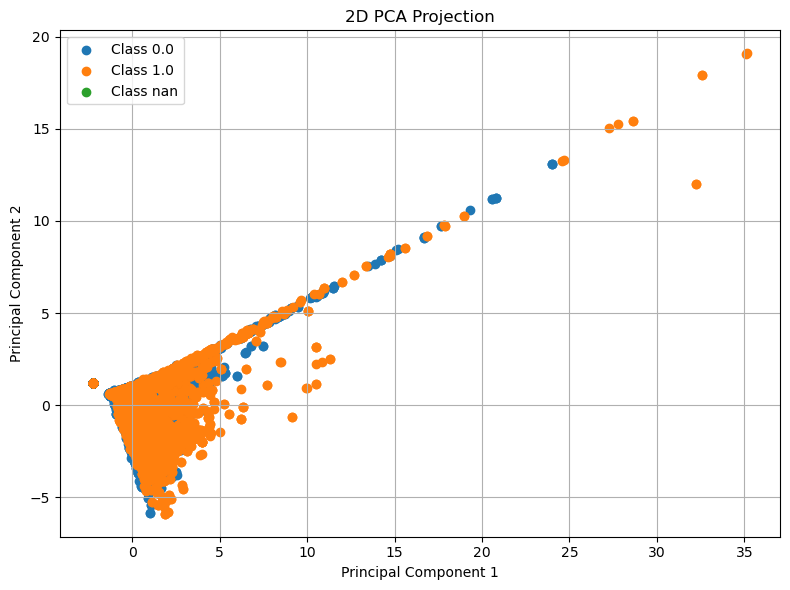

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for label in pd.unique(y):
    plt.scatter(
        X_pca[y == label, 0],
        X_pca[y == label, 1],
        label=f"Class {label}"
    )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Projection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### PCA for 95% retention

In [6]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

### Checking dataset

In [7]:
# Count missing labels
print("Missing Label values:", full_df['Label'].isna().sum())

# Preview rows with missing labels
print(full_df[full_df['Label'].isna()].head())

# Wrap PCA result with labels into DataFrame
pca_df = pd.DataFrame(X_pca)
pca_df['Label'] = y.reset_index(drop=True)

# Drop rows with missing labels
pca_df = pca_df.dropna(subset=['Label'])

# Extract clean features and labels
X_pca_clean = pca_df.drop(columns=['Label']).values
y_clean = pca_df['Label'].values

# Drop rows with NaN in Label
full_df = full_df.dropna(subset=['Label']).reset_index(drop=True)

Missing Label values: 4
     exp video  segment  frame  n_masks  n_masks^3 mask_area mask_centroid  \
635  NaN   NaN      NaN    NaN      NaN        NaN       NaN           NaN   
636  NaN   NaN      NaN    NaN      NaN        NaN       NaN           NaN   
637  NaN   NaN      NaN    NaN      NaN        NaN       NaN           NaN   
638  NaN   NaN      NaN    NaN      NaN        NaN       NaN           NaN   

    mask_conf mask_strength  ... avg_bbox_area avg_mask_strength  \
635       NaN           NaN  ...           NaN               NaN   
636       NaN           NaN  ...           NaN               NaN   
637       NaN           NaN  ...           NaN               NaN   
638       NaN           NaN  ...           NaN               NaN   

    avg_bbox_width avg_bbox_height  mask_centroid_dist  bbox_centroid_dist  \
635            NaN             NaN                 NaN                 NaN   
636            NaN             NaN                 NaN                 NaN   
637       

## Model

### Data check

In [8]:
print(X_pca_clean.shape)
print(y_clean.shape)

(22416, 4)
(22416,)


### Train-Test split and model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# Train
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7312667261373773
Confusion Matrix:
 [[2634  449]
 [ 756  645]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.85      0.81      3083
         1.0       0.59      0.46      0.52      1401

    accuracy                           0.73      4484
   macro avg       0.68      0.66      0.67      4484
weighted avg       0.72      0.73      0.72      4484



### ROC/AUC

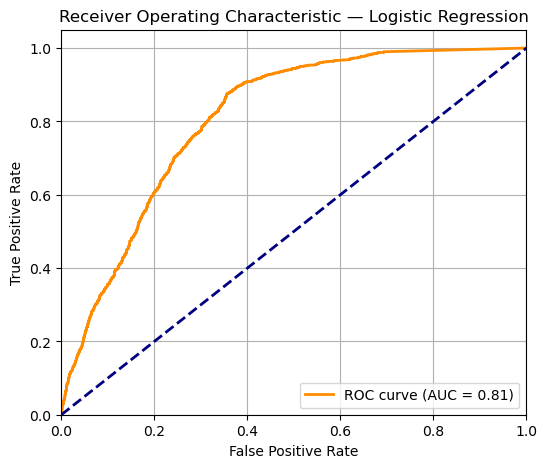

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# predicted probabilities for the positive class (class 1)
y_scores = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic — Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## SMOTE

Original class distribution: {0.0: 12328, 1.0: 5604}
After SMOTE: {0.0: 12328, 1.0: 12328}
Accuracy: 0.7203389830508474
Confusion Matrix:
 [[2084  999]
 [ 255 1146]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.68      0.77      3083
         1.0       0.53      0.82      0.65      1401

    accuracy                           0.72      4484
   macro avg       0.71      0.75      0.71      4484
weighted avg       0.78      0.72      0.73      4484



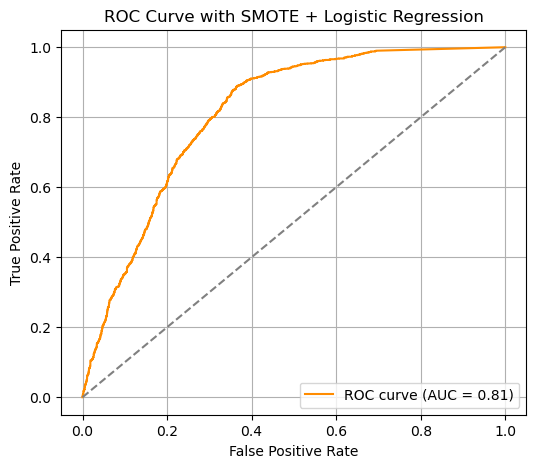

In [11]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Initializing SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("After SMOTE:", dict(zip(*np.unique(y_train_smote, return_counts=True))))

# Training
model = LogisticRegression(max_iter=1000)
model.fit(X_train_smote, y_train_smote)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve
y_scores = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with SMOTE + Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# LOGISTIC REGRESSION USING ROLLING DATA

### Adding Rolling Data

In [12]:
full_df

,exp,video,segment,frame,n_masks,n_masks^3,mask_area,mask_centroid,mask_conf,mask_strength,...,avg_bbox_area,avg_mask_strength,avg_bbox_width,avg_bbox_height,mask_centroid_dist,bbox_centroid_dist,Label,n^4,n_masks^4,Unnamed: 15
0,04_07_2024,2024-07-04_11_51_08_772,2.0,100.0,1.0,1.0,[48],"[[277.0, 155.0]]",[0.38094273],[199.52],...,56.0,199.520,8.0,8.0,0.00,0.00,0.0,NaN,NaN,NaN
1,04_07_2024,2024-07-04_11_51_08_772,2.0,101.0,0.0,0.0,[],[],[],[],...,0.0,0.000,0.0,0.0,0.00,0.00,0.0,NaN,NaN,NaN
2,04_07_2024,2024-07-04_11_51_08_772,2.0,102.0,0.0,0.0,[],[],[],[],...,0.0,0.000,0.0,0.0,0.00,0.00,0.0,NaN,NaN,NaN
3,04_07_2024,2024-07-04_11_51_08_772,2.0,103.0,2.0,8.0,"[118, 198]","[[282.0, 164.0], [281.0, 162.0]]","[0.58505154, 0.40290353]","[198.36, 198.99]",...,183.0,198.675,10.5,10.5,2.24,2.24,0.0,NaN,NaN,NaN
4,04_07_2024,2024-07-04_11_51_08_772,2.0,104.0,2.0,8.0,"[118, 198]","[[282.0, 164.0], [281.0, 162.0]]","[0.5849741, 0.40308228]","[198.36, 198.99]",...,183.0,198.675,10.5,10.5,2.24,2.24,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22411,22_08_2024,2024-08-22_15_45_00_000,2.0,3443.0,0.0,NaN,[],[],[],[],...,0.0,0.000,0.0,0.0,0.00,0.00,0.0,NaN,0.0,NaN
22412,22_08_2024,2024-08-22_15_45_00_000,2.0,3444.0,0.0,NaN,[],[],[],[],...,0.0,0.000,0.0,0.0,0.00,0.00,0.0,NaN,0.0,NaN
22413,22_08_2024,2024-08-22_15_45_00_000,2.0,3445.0,0.0,NaN,[],[],[],[],...,0.0,0.000,0.0,0.0,0.00,0.00,0.0,NaN,0.0,NaN
22414,22_08_2024,2024-08-22_15_45_00_000,2.0,3446.0,0.0,NaN,[],[],[],[],...,0.0,0.000,0.0,0.0,0.00,0.00,0.0,NaN,0.0,NaN


In [13]:
X.head()

,n_masks,avg_mask_area,avg_bbox_area,avg_mask_strength,avg_bbox_width,avg_bbox_height,mask_centroid_dist,bbox_centroid_dist
0,1.0,48.0,56.0,199.520,8.0,8.0,0.00,0.00
1,0.0,0.0,0.0,0.000,0.0,0.0,0.00,0.00
2,0.0,0.0,0.0,0.000,0.0,0.0,0.00,0.00
3,2.0,158.0,183.0,198.675,10.5,10.5,2.24,2.24
4,2.0,158.0,183.0,198.675,10.5,10.5,2.24,2.24


In [14]:
cols_drop = [ 'video',  'frame', 'n_masks^3', 'mask_area',
    'mask_centroid', 'mask_conf', 'mask_strength', 'bbox_id', 'bbox_area',
    'bbox_centroid', 'bbox_dim',  'n^4', 'n_masks^4',
    'Unnamed: 15']

### Rolling Function

In [15]:
test_df = pd.DataFrame()
def rolling_func(x, df):
    n_diff = x
    cols = list(df.columns)
    for col in cols:
        if col in ['Label', 'exp', 'segment']:
            continue
        for j in range(1, n_diff+1):
            try:
                df[col + "_" + str(j)] = df.groupby(['exp', 'segment'])[col].diff(j).fillna(0)
            except:
                print(col)
                print(df.head())
    return df.drop(['exp', 'segment'], axis=1)

### Performance Function

In [16]:
def perf(ytrain, ytrain_pred, ytest, ytest_pred):
    return {
        'train_score': accuracy_score(ytrain, ytrain_pred),
        'test_score': accuracy_score(ytest, ytest_pred),
        'conf_matrix': confusion_matrix(ytest, ytest_pred),
        'cls_rep_str': classification_report(ytest, ytest_pred),
        'cls_rep': classification_report(ytest, ytest_pred, output_dict=True)
    }

### Preprocessing Funtion

In [17]:
def preprocess(xtrain, ytrain, xtest, ytest, scaler, smote):
    xtrain_scaled = scaler.fit_transform(xtrain)
    xtest_scaled = scaler.fit_transform(xtest)
    xtrain_smote, ytrain_smote = smote.fit_resample(xtrain_scaled, ytrain)
    return xtrain_smote, xtest_scaled, ytrain_smote, ytest

### Model

In [18]:
score = []
scaler = StandardScaler()
smote = SMOTE(random_state=42)

for k in range(7):
    x_added = full_df.copy()
    x_added.drop(cols_drop, axis=1, inplace=True)
    df_rolled = rolling_func(k, x_added)
    xtrain, xtest, ytrain, ytest = train_test_split(df_rolled.drop('Label', axis=1), df_rolled['Label'], test_size= 0.2, random_state=42, stratify=df_rolled['Label'])
    xtrain_proc, xtest_proc, ytrain_proc, ytest_proc = preprocess(xtrain, ytrain, xtest, ytest, scaler, smote)
    model = LogisticRegression(max_iter=1000)
    model.fit(xtrain_proc, ytrain_proc)
    ypred_test = model.predict(xtest_proc)
    ypred_train = model.predict(xtrain_proc)
    score.append(perf(ytrain_proc, ypred_train, ytest_proc, ypred_test))
    print(f"Completed running roll {k} \nTest Acc: {score[k]['test_score']} \nClass Rep:\n {score[k]['cls_rep_str']}")

Completed running roll 0 
Test Acc: 0.7526761819803747 
Class Rep:
               precision    recall  f1-score   support

         0.0       0.90      0.72      0.80      3083
         1.0       0.57      0.82      0.67      1401

    accuracy                           0.75      4484
   macro avg       0.74      0.77      0.74      4484
weighted avg       0.80      0.75      0.76      4484

Completed running roll 1 
Test Acc: 0.7582515611061552 
Class Rep:
               precision    recall  f1-score   support

         0.0       0.91      0.72      0.80      3083
         1.0       0.58      0.83      0.68      1401

    accuracy                           0.76      4484
   macro avg       0.74      0.78      0.74      4484
weighted avg       0.80      0.76      0.77      4484

Completed running roll 2 
Test Acc: 0.7582515611061552 
Class Rep:
               precision    recall  f1-score   support

         0.0       0.91      0.72      0.80      3083
         1.0       0.58      0.83

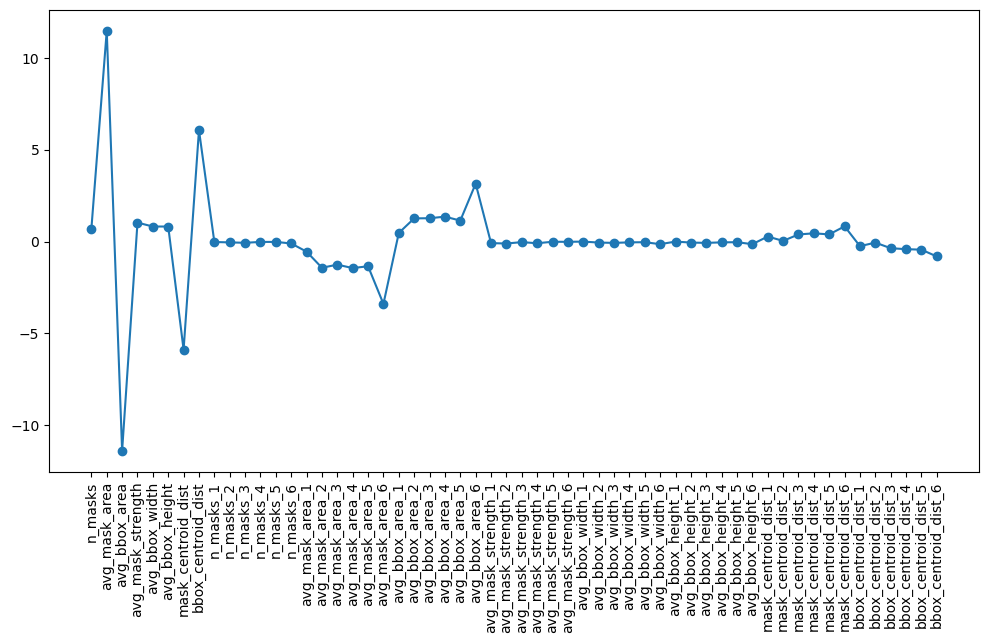

In [19]:
plt.figure(figsize=(12,6))
plt.plot(list(df_rolled.drop('Label', axis=1).columns), model.coef_.reshape(56,), marker='o')
plt.xticks(rotation=90)
plt.show()

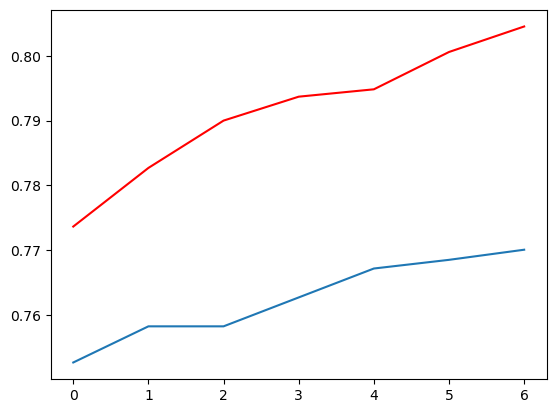

In [20]:
plt.plot([ele['test_score'] for ele in score])
plt.plot([ele['train_score'] for ele in score], color='r')

# DIFFERENT MODELS ON ROLLING DATA

### DT, RF & KNN

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Initialise models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=10,
    min_samples_split=10,
    random_state=42
),
    'RandomForest': RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    min_samples_leaf=15,
    min_samples_split=15,
    max_features='sqrt',
    random_state=42
),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Suppress ConvergenceWarning
#import warnings
#from sklearn.exceptions import ConvergenceWarning
#warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Store scores for each roll and model
all_scores = {model_name: [] for model_name in models}

for k in range(7):
    print(f"\n===================== ROLL {k+1} =====================")
    x_added = full_df.copy()
    x_added.drop(cols_drop, axis=1, inplace=True)
    df_rolled = rolling_func(k, x_added)
    
    X = df_rolled.drop('Label', axis=1)
    y = df_rolled['Label']
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    x_train_proc, x_test_proc, y_train_proc, y_test_proc = preprocess(xtrain, ytrain, xtest, ytest, scaler, smote)

    for model_name, model in models.items():
        model.fit(x_train_proc, y_train_proc)
        y_pred_train = model.predict(xtrain_proc)
        y_pred_test = model.predict(xtest_proc)
        result = perf(y_train_proc, y_pred_train, y_test_proc, y_pred_test)
        all_scores[model_name].append(result)

        print(f"Train Accuracy: {result['train_score']:.4f}")
        print(f"Test Accuracy: {result['test_score']:.4f}")
        print("Classification Report (Threshold = 0.5):\n", result['cls_rep_str'])


===================== ROLL 1 =====================
Train Accuracy: 0.8045
Test Accuracy: 0.7701
Classification Report (Threshold = 0.5):
               precision    recall  f1-score   support

         0.0       0.91      0.74      0.82      3083
         1.0       0.59      0.83      0.69      1401

    accuracy                           0.77      4484
   macro avg       0.75      0.79      0.75      4484
weighted avg       0.81      0.77      0.78      4484

Train Accuracy: 0.8281
Test Accuracy: 0.7161
Classification Report (Threshold = 0.5):
               precision    recall  f1-score   support

         0.0       0.94      0.63      0.75      3083
         1.0       0.53      0.90      0.67      1401

    accuracy                           0.72      4484
   macro avg       0.73      0.77      0.71      4484
weighted avg       0.81      0.72      0.73      4484

Train Accuracy: 0.8254
Test Accuracy: 0.7442
Classification Report (Threshold = 0.5):
               precision    recall

### Model Function (LR, DT, RF, KNN, GB, ExGB, MLP, SVM)

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

def evaluate_models_and_save(full_df, cols_drop, save_dir='model_results', max_roll=7):
    os.makedirs(save_dir, exist_ok=True)
    scaler = StandardScaler()
    smote = SMOTE(random_state=42)

    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'DecisionTree': DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=10, random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15, min_samples_split=15, max_features='sqrt', random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=10),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100,learning_rate=0.05,max_depth=4,subsample=0.8,colsample_bytree=0.8, scale_pos_weight=1,eval_metric='logloss'),
        'MLP': MLPClassifier(hidden_layer_sizes=(60,), activation='relu', solver='adam', max_iter=1000, random_state=42, alpha=0.01, early_stopping=True),
        'SVM': SVC(kernel='rbf', C=0.5, gamma='scale', probability=True, random_state=42)
    }

    # Master list to hold all rows
    all_results = []

    for k in range(max_roll):
        print(f"\n===================== ROLL {k} =====================")
        x_added = full_df.copy()
        x_added.drop(cols_drop, axis=1, inplace=True)
        df_rolled = rolling_func(k, x_added)

        X = df_rolled.drop('Label', axis=1)
        y = df_rolled['Label']

        xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        xtrain_proc, xtest_proc, ytrain_proc, ytest_proc = preprocess(xtrain, ytrain, xtest, ytest, scaler, smote)

        for model_name, model in models.items():
            model.fit(xtrain_proc, ytrain_proc)
            ytrain_pred = model.predict(xtrain_proc)
            ytest_pred = model.predict(xtest_proc)
            result = perf(ytrain_proc, ytrain_pred, ytest_proc, ytest_pred)

            # Flatten classification report
            for label, metrics in result['cls_rep'].items():
                if label == 'accuracy':
                    continue
                row = {
                    'Roll': k,
                    'Model': model_name,
                    'Label': label,
                    'Train_Accuracy': result['train_score'],
                    'Test_Accuracy': result['test_score'],
                    'Precision': metrics.get('precision', None),
                    'Recall': metrics.get('recall', None),
                    'F1-score': metrics.get('f1-score', None),
                    'Support': metrics.get('support', None)
                }
                all_results.append(row)


            print(f"\nModel: {model_name}")
            print(f"Train Accuracy: {result['train_score']:.4f}")
            print(f"Test Accuracy: {result['test_score']:.4f}")
            print(f"Classification Report (Threshold = 0.5):\n {result['cls_rep_str']}")

    # Convert all results to DataFrame
    results_df = pd.DataFrame(all_results)

    # Save to CSV
    output_file = os.path.join(save_dir, 'model_performance_summary.csv')
    results_df.to_csv(output_file, index=False)
    print(f"\nAll model results saved to: {output_file}")

    return results_df

In [23]:
results_df = evaluate_models_and_save(full_df, cols_drop, save_dir='outputs', max_roll=7)


===================== ROLL 0 =====================

Model: LogisticRegression
Train Accuracy: 0.7736
Test Accuracy: 0.7527
Classification Report (Threshold = 0.5):
               precision    recall  f1-score   support

         0.0       0.90      0.72      0.80      3083
         1.0       0.57      0.82      0.67      1401

    accuracy                           0.75      4484
   macro avg       0.74      0.77      0.74      4484
weighted avg       0.80      0.75      0.76      4484


Model: DecisionTree
Train Accuracy: 0.8123
Test Accuracy: 0.7721
Classification Report (Threshold = 0.5):
               precision    recall  f1-score   support

         0.0       0.93      0.73      0.81      3083
         1.0       0.59      0.87      0.71      1401

    accuracy                           0.77      4484
   macro avg       0.76      0.80      0.76      4484
weighted avg       0.82      0.77      0.78      4484


Model: RandomForest
Train Accuracy: 0.8295
Test Accuracy: 0.7750
Classi

In [24]:
from IPython.display import FileLink
FileLink(r'outputs/model_performance_summary.csv')

C:\Users\AVINASH\Avichal\outputs\model_performance_summary.csv

# LSTM MODEL

### LSTM Annotation

In [25]:
import pandas as pd

df_LSTM = pd.read_csv(r"C:\Users\AVINASH\Desktop\Avichal\Visualized Data\combined_data.csv")

df_LSTM['label_LSTM'] = (
    df_LSTM['Label']
    .rolling(window=5, min_periods=5) 
    .apply(lambda x: 1 if x.sum() >= 3 else 0)
    .shift(0)
    .fillna(0)
    .astype(int)
)

# Save to CSV
df_LSTM.to_csv("combined_data_with_label_LSTM.csv", index=False)

### Padding

In [26]:
df_LSTM['is_padding'] = 0
df_LSTM = df_LSTM.sort_values(by=['exp', 'video', 'segment'])

grouped_with_padding = []

# Group by exp, video, segment
for _, group in df_LSTM.groupby(['exp', 'video', 'segment']):
    grouped_with_padding.append(group)

    # Create a padding row
    padding_row = {
        col: 0 if pd.api.types.is_numeric_dtype(df_LSTM[col]) else "" 
        for col in df_LSTM.columns if col != 'is_padding'
    }
    padding_row['is_padding'] = 1
    zero_row = pd.DataFrame([padding_row])
    grouped_with_padding.append(zero_row)

df_padded = pd.concat(grouped_with_padding, ignore_index=True)

# Save to CSV
df_padded.to_csv("combined_data_grouped_with_padding_flag.csv", index=False)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Masking
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Recall, Precision

df_padded.head()

,exp,video,segment,frame,n_masks,n_masks^3,mask_area,mask_centroid,mask_conf,mask_strength,...,avg_bbox_width,avg_bbox_height,mask_centroid_dist,bbox_centroid_dist,Label,n^4,n_masks^4,Unnamed: 15,label_LSTM,is_padding
0,04_07_2024,2024-07-04_11_51_08_772,2.0,100.0,1,1.0,[48],"[[277.0, 155.0]]",[0.38094273],[199.52],...,8.0,8.0,0.00,0.00,0.0,NaN,NaN,NaN,0,0
1,04_07_2024,2024-07-04_11_51_08_772,2.0,101.0,0,0.0,[],[],[],[],...,0.0,0.0,0.00,0.00,0.0,NaN,NaN,NaN,0,0
2,04_07_2024,2024-07-04_11_51_08_772,2.0,102.0,0,0.0,[],[],[],[],...,0.0,0.0,0.00,0.00,0.0,NaN,NaN,NaN,0,0
3,04_07_2024,2024-07-04_11_51_08_772,2.0,103.0,2,8.0,"[118, 198]","[[282.0, 164.0], [281.0, 162.0]]","[0.58505154, 0.40290353]","[198.36, 198.99]",...,10.5,10.5,2.24,2.24,0.0,NaN,NaN,NaN,0,0
4,04_07_2024,2024-07-04_11_51_08_772,2.0,104.0,2,8.0,"[118, 198]","[[282.0, 164.0], [281.0, 162.0]]","[0.5849741, 0.40308228]","[198.36, 198.99]",...,10.5,10.5,2.24,2.24,0.0,NaN,NaN,NaN,0,0


In [28]:
cols_drop_lstm = [ 'exp', 'segment', 'video',  'frame', 'n_masks^3', 'mask_area',
    'mask_centroid', 'mask_conf', 'mask_strength', 'bbox_id', 'bbox_area',
    'bbox_centroid', 'bbox_dim',  'Label']

In [29]:
X_train.shape

(17932, 4)

### Model

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Masking
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.metrics import Recall, Precision

import keras_tuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import CSVLogger

ImportError: Traceback (most recent call last):
  File "C:\Users\ADMIN\anaconda3\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [9]:
cols_drop_lstm = [ 'exp', 'segment', 'video',  'frame', 'path', 'n_masks^3', 'mask_area',
    'mask_centroid', 'mask_conf', 'mask_strength', 'bbox_id', 'bbox_area',
    'bbox_centroid', 'bbox_dim',  'Label']

In [10]:
df_lstm = pd.read_csv(r"F:\Work\Misc\Mentees\SodiumDisposal\combined_data_grouped_with_padding_flag_Modified.csv")
print(df_lstm['is_padding'].value_counts())
df_lstm.drop(cols_drop_lstm, axis=1, inplace=True)

numeric_cols = df_lstm[df_lstm.columns].select_dtypes(include='number').columns
feature_cols = [col for col in df_lstm.columns if col not in ['label_LSTM', 'is_padding']]


def build_sequences(df_lstm, features, target_col='label_LSTM', window_size=10):
    X_seqs, y_seqs = [], []

    pad_indices = df_lstm[df_lstm['is_padding'] == 1].index.tolist()
    start_idx = 0

    for pad_idx in pad_indices + [len(df_lstm)]:
        chunk = df_lstm.iloc[start_idx:pad_idx]
        chunk = chunk[chunk['is_padding'] == 0]

        if len(chunk) >= window_size:
            for i in range(len(chunk) - window_size + 1):
                window = chunk.iloc[i:i + window_size]
                X_seqs.append(window[features].values)
                y_seqs.append(window[target_col].iloc[-1])

        start_idx = pad_idx + 1

    print(f"Total sequences built: {len(X_seqs)}")
    return np.array(X_seqs), np.array(y_seqs)


X, y = build_sequences(df_lstm, feature_cols)
print("X shape:", X.shape)
print("y shape:", y.shape)


scaler = StandardScaler()
df_lstm[numeric_cols] = scaler.fit_transform(df_lstm[numeric_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train).astype(int), weights))

model = Sequential([
#     Masking(mask_value=0., input_shape=(X.shape[1], X.shape[2])),
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(), Precision()])
model.summary()

# history_10_new = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.2, class_weight=class_weights)
# model.save("lstm_model_best_recall_50ep.h5")

# # Evaluate on Test Set
# y_pred_prob = model.predict(X_test)

# # Threshold Tuning
# best_thresh = 0.5
# best_recall = 0
# best_report = None
# best_preds = None

# print("\nTuning Threshold to Maximize Recall for Class 1:\n")
# for thresh in np.arange(0.1, 0.6, 0.05):
#     y_pred_class = (y_pred_prob > thresh).astype(int)
#     report = classification_report(y_test, y_pred_class, output_dict=True, zero_division=0)

#     recall = report.get('1', {}).get('recall', 0)
#     precision = report.get('1', {}).get('precision', 0)

#     print(f"Threshold: {thresh:.2f} | Recall: {recall:.4f} | Precision: {precision:.4f}")

#     if recall > best_recall:
#         best_recall = recall
#         best_thresh = thresh
#         best_report = report
#         best_preds = y_pred_class

# # Print Best Threshold Report
# print(f"\nBest Threshold = {best_thresh:.2f} with Recall = {best_recall:.4f}\n")
# print(classification_report(y_test, best_preds))

0    10047
1       55
Name: is_padding, dtype: int64
Total sequences built: 9559
X shape: (9559, 10, 8)
y shape: (9559,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 64)            18688     
                                                                 
 dropout_4 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,137
Trainable params: 31,137
Non-trainable params: 0
_________________________________________________________________


In [21]:
X_train

array([[[2.00000000e+00, 2.45000000e+02, 3.27500000e+02, ...,
         1.45000000e+01, 1.38290000e+02, 1.38410000e+02],
        [1.00000000e+00, 1.40000000e+02, 1.69000000e+02, ...,
         1.30000000e+01, 0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 1.40000000e+02, 1.69000000e+02, ...,
         1.30000000e+01, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.00000000e+00, 7.61000000e+02, 1.05400000e+03, ...,
         3.40000000e+01, 0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 7.59000000e+02, 1.05400000e+03, ...,
         3.40000000e+01, 0.00000000e+00, 0.00000000e+00],
        [2.00000000e+00, 4.98500000e+02, 7.30500000e+02, ...,
         2.10000000e+01, 1.90210000e+02, 1.91320000e+02]],

       [[6.00000000e+00, 5.97000000e+02, 9.31666667e+02, ...,
         2.33333333e+01, 1.71800000e+02, 1.72690000e+02],
        [8.00000000e+00, 9.95750000e+02, 2.09662500e+03, ...,
         2.97500000e+01, 1.43200000e+02, 1.43200000e+02],
        [8.00000000e+00, 

In [19]:
df_lstm.columns

Index(['n_masks', 'avg_mask_area', 'avg_bbox_area', 'avg_mask_strength',
       'avg_bbox_width', 'avg_bbox_height', 'mask_centroid_dist',
       'bbox_centroid_dist', 'label_LSTM', 'is_padding'],
      dtype='object')

In [28]:
# Hyper parameter Tuning


# csv_logger = CSVLogger('training_log.csv', append=True)
# from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation='tanh',
                   input_shape=(10, 8),  # example input shape
                   dropout=hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy',Recall(), Precision()])
    return model

# tuner = kt.RandomSearch(build_model,
#                      objective='val_accuracy',
#                      max_trials=10,
#                      directory='tuner_results',
#                      project_name='lstm_tuning')

# logger = ResultLogger()
# tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[csv_logger])

In [39]:
results_df = pd.DataFrame(logger.trial_results)
results_df.head()
# results_df.to_csv("random_search_results.csv", index=False)

""


In [47]:
from itertools import product
units_list = [32, 64, 96]
dropout_list = [0.2, 0.3]
hist_list = []
product(units_list, dropout_list)

In [69]:
for units in [16, 32, 64, 96]:
    model = Sequential()
    model.add(LSTM(units=units,
                   activation='tanh',
                   input_shape=(10, 8)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate= 0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy',Recall(), Precision()])
    history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)
#     model.save("lstm_model_best_recall_50ep.h5")

    # Evaluate on Test Set
    y_pred_prob = model.predict(X_test)
    hist_list.append(history)
    y_pred_class = (y_pred_prob > 0.5).astype(int)
    report = classification_report(y_test, y_pred_class, output_dict=True, zero_division=0)
    rep_list.append(report)

Epoch 1/30
192/192 [==============================] - 159s 337ms/step - loss: 0.7001 - accuracy: 0.5378 - recall_9: 0.7152 - precision_9: 0.6618 - val_loss: 0.6617 - val_accuracy: 0.6523 - val_recall_9: 0.8753 - val_precision_9: 0.7069
Epoch 2/30
192/192 [==============================] - 34s 175ms/step - loss: 0.6358 - accuracy: 0.6824 - recall_9: 0.9206 - precision_9: 0.7146 - val_loss: 0.6104 - val_accuracy: 0.7346 - val_recall_9: 0.9615 - val_precision_9: 0.7424
Epoch 3/30
192/192 [==============================] - 33s 172ms/step - loss: 0.5997 - accuracy: 0.7402 - recall_9: 0.9664 - precision_9: 0.7443 - val_loss: 0.5847 - val_accuracy: 0.7680 - val_recall_9: 0.9872 - val_precision_9: 0.7595
Epoch 4/30
192/192 [==============================] - 33s 173ms/step - loss: 0.5773 - accuracy: 0.7654 - recall_9: 0.9791 - precision_9: 0.7600 - val_loss: 0.5647 - val_accuracy: 0.7778 - val_recall_9: 0.9881 - val_precision_9: 0.7673
Epoch 5/30
192/192 [==============================] - 34s 1

192/192 [==============================] - 33s 171ms/step - loss: 0.3683 - accuracy: 0.8494 - recall_11: 0.9510 - precision_11: 0.8538 - val_loss: 0.3584 - val_accuracy: 0.8634 - val_recall_11: 0.9450 - val_precision_11: 0.8737
Epoch 10/30
192/192 [==============================] - 35s 181ms/step - loss: 0.3635 - accuracy: 0.8514 - recall_11: 0.9508 - precision_11: 0.8560 - val_loss: 0.3514 - val_accuracy: 0.8627 - val_recall_11: 0.9468 - val_precision_11: 0.8717
Epoch 11/30
192/192 [==============================] - 36s 186ms/step - loss: 0.3591 - accuracy: 0.8524 - recall_11: 0.9508 - precision_11: 0.8571 - val_loss: 0.3486 - val_accuracy: 0.8634 - val_recall_11: 0.9487 - val_precision_11: 0.8712
Epoch 12/30
192/192 [==============================] - 35s 181ms/step - loss: 0.3550 - accuracy: 0.8543 - recall_11: 0.9501 - precision_11: 0.8597 - val_loss: 0.3433 - val_accuracy: 0.8654 - val_recall_11: 0.9496 - val_precision_11: 0.8728
Epoch 13/30
192/192 [==============================]

Epoch 13/30
192/192 [==============================] - 33s 172ms/step - loss: 0.3209 - accuracy: 0.8640 - recall_12: 0.9572 - precision_12: 0.8656 - val_loss: 0.3223 - val_accuracy: 0.8712 - val_recall_12: 0.9569 - val_precision_12: 0.8744
Epoch 14/30
192/192 [==============================] - 32s 170ms/step - loss: 0.3186 - accuracy: 0.8624 - recall_12: 0.9558 - precision_12: 0.8647 - val_loss: 0.3193 - val_accuracy: 0.8719 - val_recall_12: 0.9578 - val_precision_12: 0.8745
Epoch 15/30
192/192 [==============================] - 33s 171ms/step - loss: 0.3168 - accuracy: 0.8663 - recall_12: 0.9607 - precision_12: 0.8659 - val_loss: 0.3175 - val_accuracy: 0.8719 - val_recall_12: 0.9578 - val_precision_12: 0.8745
Epoch 16/30
192/192 [==============================] - 33s 170ms/step - loss: 0.3116 - accuracy: 0.8661 - recall_12: 0.9593 - precision_12: 0.8666 - val_loss: 0.3162 - val_accuracy: 0.8712 - val_recall_12: 0.9597 - val_precision_12: 0.8725
Epoch 17/30
192/192 [===================

In [52]:
# Fine Tuning
units_list = [32, 64, 96]
dropout_list = [0.2, 0.3]
hist_list = []
rep_list = []
for units, dropout in product(units_list, dropout_list):    
    print(f"Units: {units}, Dropout: {dropout}")
    model = Sequential()
    model.add(LSTM(units=units,
                   activation='tanh',
                   input_shape=(10, 8),  # example input shape
                   dropout=dropout))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate= 0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy',Recall(), Precision()])
    history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)
#     model.save("lstm_model_best_recall_50ep.h5")

    # Evaluate on Test Set
    y_pred_prob = model.predict(X_test)
    hist_list.append(history)
    y_pred_class = (y_pred_prob > 0.5).astype(int)
    report = classification_report(y_test, y_pred_class, output_dict=True, zero_division=0)
    rep_list.append(report)

Units: 32, Dropout: 0.2
Epoch 1/30
192/192 [==============================] - 10s 20ms/step - loss: 0.7851 - accuracy: 0.4268 - recall_3: 0.3984 - precision_3: 0.6603 - val_loss: 0.6154 - val_accuracy: 0.7288 - val_recall_3: 0.8653 - val_precision_3: 0.7789
Epoch 2/30
192/192 [==============================] - 2s 9ms/step - loss: 0.6290 - accuracy: 0.6551 - recall_3: 0.7603 - precision_3: 0.7558 - val_loss: 0.5570 - val_accuracy: 0.8007 - val_recall_3: 0.9450 - val_precision_3: 0.8080
Epoch 3/30
192/192 [==============================] - 2s 9ms/step - loss: 0.5805 - accuracy: 0.7120 - recall_3: 0.8394 - precision_3: 0.7742 - val_loss: 0.5345 - val_accuracy: 0.8124 - val_recall_3: 0.9578 - val_precision_3: 0.8126
Epoch 4/30
192/192 [==============================] - 2s 9ms/step - loss: 0.5572 - accuracy: 0.7515 - recall_3: 0.9006 - precision_3: 0.7825 - val_loss: 0.5121 - val_accuracy: 0.8196 - val_recall_3: 0.9688 - val_precision_3: 0.8137
Epoch 5/30
192/192 [==========================

Epoch 6/30
192/192 [==============================] - 2s 10ms/step - loss: 0.5027 - accuracy: 0.7992 - recall_4: 0.9517 - precision_4: 0.8025 - val_loss: 0.4589 - val_accuracy: 0.8373 - val_recall_4: 0.9707 - val_precision_4: 0.8299
Epoch 7/30
192/192 [==============================] - 2s 9ms/step - loss: 0.4817 - accuracy: 0.8058 - recall_4: 0.9563 - precision_4: 0.8064 - val_loss: 0.4339 - val_accuracy: 0.8386 - val_recall_4: 0.9688 - val_precision_4: 0.8323
Epoch 8/30
192/192 [==============================] - 2s 9ms/step - loss: 0.4668 - accuracy: 0.8104 - recall_4: 0.9568 - precision_4: 0.8106 - val_loss: 0.4290 - val_accuracy: 0.8412 - val_recall_4: 0.9496 - val_precision_4: 0.8464
Epoch 9/30
192/192 [==============================] - 2s 9ms/step - loss: 0.4578 - accuracy: 0.8145 - recall_4: 0.9522 - precision_4: 0.8170 - val_loss: 0.4140 - val_accuracy: 0.8516 - val_recall_4: 0.9597 - val_precision_4: 0.8512
Epoch 10/30
192/192 [==============================] - 2s 8ms/step - lo

Epoch 11/30
192/192 [==============================] - 2s 11ms/step - loss: 0.4110 - accuracy: 0.8339 - recall_5: 0.9568 - precision_5: 0.8340 - val_loss: 0.3787 - val_accuracy: 0.8562 - val_recall_5: 0.9478 - val_precision_5: 0.8638
Epoch 12/30
192/192 [==============================] - 2s 11ms/step - loss: 0.4047 - accuracy: 0.8368 - recall_5: 0.9577 - precision_5: 0.8364 - val_loss: 0.3748 - val_accuracy: 0.8582 - val_recall_5: 0.9487 - val_precision_5: 0.8654
Epoch 13/30
192/192 [==============================] - 2s 11ms/step - loss: 0.4004 - accuracy: 0.8382 - recall_5: 0.9556 - precision_5: 0.8390 - val_loss: 0.3752 - val_accuracy: 0.8549 - val_recall_5: 0.9533 - val_precision_5: 0.8588
Epoch 14/30
192/192 [==============================] - 2s 11ms/step - loss: 0.3993 - accuracy: 0.8372 - recall_5: 0.9540 - precision_5: 0.8390 - val_loss: 0.3754 - val_accuracy: 0.8542 - val_recall_5: 0.9478 - val_precision_5: 0.8617
Epoch 15/30
192/192 [==============================] - 2s 13ms/s

Epoch 16/30
192/192 [==============================] - 2s 12ms/step - loss: 0.4109 - accuracy: 0.8298 - recall_6: 0.9535 - precision_6: 0.8317 - val_loss: 0.3789 - val_accuracy: 0.8562 - val_recall_6: 0.9542 - val_precision_6: 0.8596
Epoch 17/30
192/192 [==============================] - 2s 11ms/step - loss: 0.4033 - accuracy: 0.8365 - recall_6: 0.9554 - precision_6: 0.8375 - val_loss: 0.3723 - val_accuracy: 0.8556 - val_recall_6: 0.9533 - val_precision_6: 0.8595
Epoch 18/30
192/192 [==============================] - 2s 11ms/step - loss: 0.4086 - accuracy: 0.8349 - recall_6: 0.9547 - precision_6: 0.8362 - val_loss: 0.3702 - val_accuracy: 0.8542 - val_recall_6: 0.9514 - val_precision_6: 0.8593
Epoch 19/30
192/192 [==============================] - 2s 11ms/step - loss: 0.4052 - accuracy: 0.8370 - recall_6: 0.9535 - precision_6: 0.8391 - val_loss: 0.3669 - val_accuracy: 0.8582 - val_recall_6: 0.9551 - val_precision_6: 0.8612
Epoch 20/30
192/192 [==============================] - 2s 11ms/s

Epoch 21/30
192/192 [==============================] - 3s 14ms/step - loss: 0.3481 - accuracy: 0.8532 - recall_7: 0.9531 - precision_7: 0.8565 - val_loss: 0.3271 - val_accuracy: 0.8706 - val_recall_7: 0.9588 - val_precision_7: 0.8724
Epoch 22/30
192/192 [==============================] - 3s 14ms/step - loss: 0.3489 - accuracy: 0.8485 - recall_7: 0.9496 - precision_7: 0.8536 - val_loss: 0.3268 - val_accuracy: 0.8712 - val_recall_7: 0.9560 - val_precision_7: 0.8750
Epoch 23/30
192/192 [==============================] - 3s 14ms/step - loss: 0.3426 - accuracy: 0.8566 - recall_7: 0.9524 - precision_7: 0.8607 - val_loss: 0.3249 - val_accuracy: 0.8732 - val_recall_7: 0.9615 - val_precision_7: 0.8734
Epoch 24/30
192/192 [==============================] - 3s 14ms/step - loss: 0.3443 - accuracy: 0.8563 - recall_7: 0.9565 - precision_7: 0.8577 - val_loss: 0.3237 - val_accuracy: 0.8739 - val_recall_7: 0.9578 - val_precision_7: 0.8767
Epoch 25/30
192/192 [==============================] - 3s 14ms/s

Epoch 26/30
192/192 [==============================] - 3s 14ms/step - loss: 0.3736 - accuracy: 0.8457 - recall_8: 0.9496 - precision_8: 0.8506 - val_loss: 0.3604 - val_accuracy: 0.8621 - val_recall_8: 0.9588 - val_precision_8: 0.8630
Epoch 27/30
192/192 [==============================] - 3s 14ms/step - loss: 0.3663 - accuracy: 0.8517 - recall_8: 0.9547 - precision_8: 0.8539 - val_loss: 0.3590 - val_accuracy: 0.8654 - val_recall_8: 0.9578 - val_precision_8: 0.8672
Epoch 28/30
192/192 [==============================] - 3s 15ms/step - loss: 0.3660 - accuracy: 0.8432 - recall_8: 0.9487 - precision_8: 0.8486 - val_loss: 0.3538 - val_accuracy: 0.8660 - val_recall_8: 0.9588 - val_precision_8: 0.8673
Epoch 29/30
192/192 [==============================] - 3s 15ms/step - loss: 0.3704 - accuracy: 0.8496 - recall_8: 0.9492 - precision_8: 0.8551 - val_loss: 0.3553 - val_accuracy: 0.8673 - val_recall_8: 0.9560 - val_precision_8: 0.8706
Epoch 30/30
60/60 [==============================] - 2s 4ms/step

In [56]:
metrics = []
for report in rep_list:
    metrics.append({
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_score_1': report['1']['f1-score'],
        'accuracy': report['accuracy']
    })

# Convert to DataFrame
df = pd.DataFrame(metrics)
print(df)

   precision_0  recall_0  f1_score_0  precision_1  recall_1  f1_score_1  \
0     0.819005  0.616695    0.703596     0.846939  0.939623    0.890877   
1     0.848718  0.563884    0.677584     0.831800  0.955472    0.889357   
2     0.844125  0.599659    0.701195     0.842809  0.950943    0.893617   
3     0.806100  0.630324    0.707457     0.850654  0.932830    0.889849   
4     0.855422  0.604770    0.708583     0.845023  0.954717    0.896527   
5     0.839329  0.596252    0.697211     0.841472  0.949434    0.892199   

   accuracy  
0  0.840481  
1  0.835251  
2  0.843096  
3  0.839958  
4  0.847280  
5  0.841004  


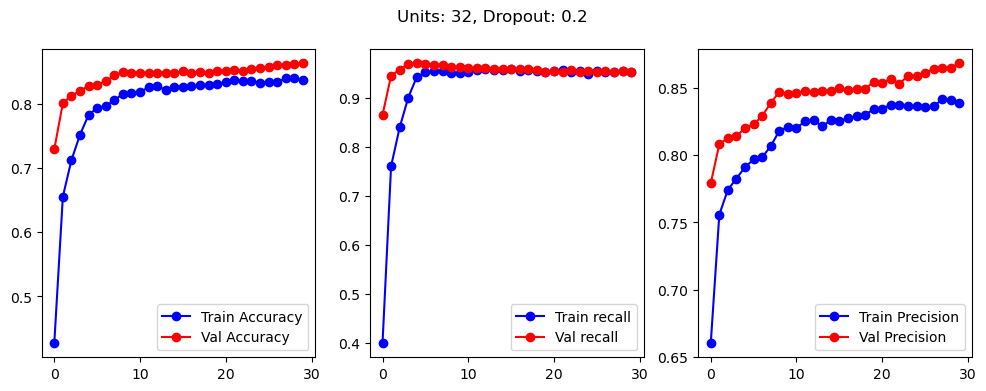

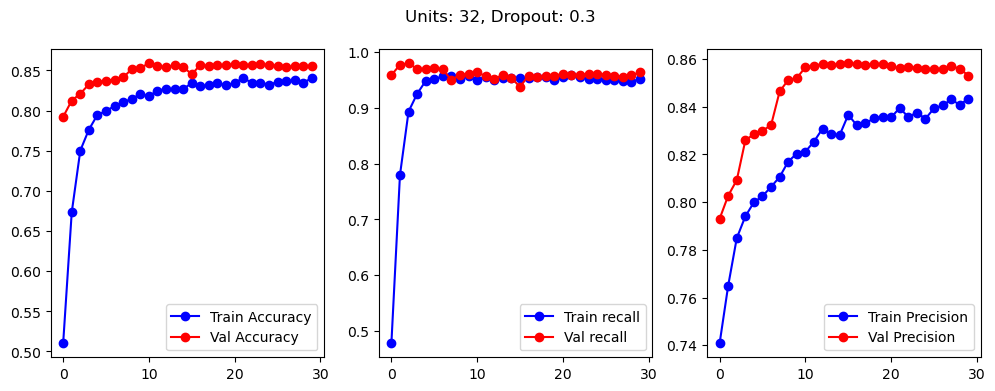

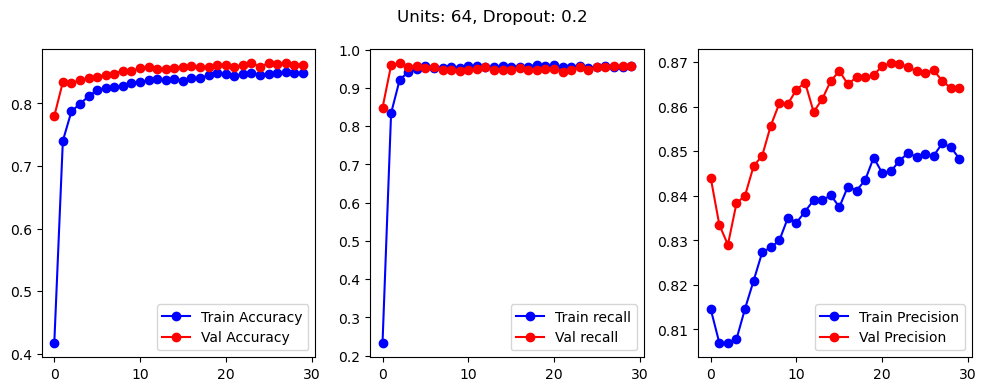

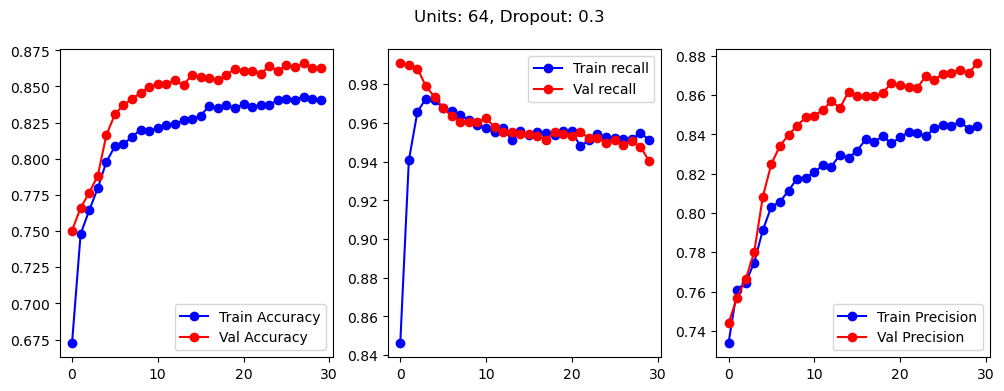

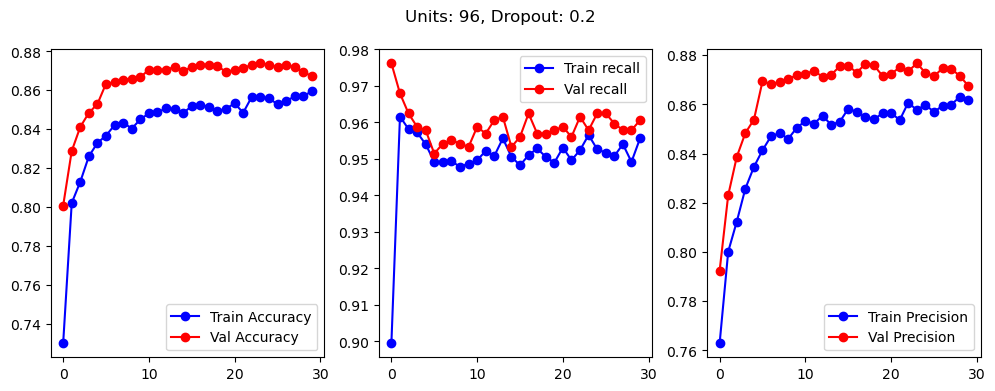

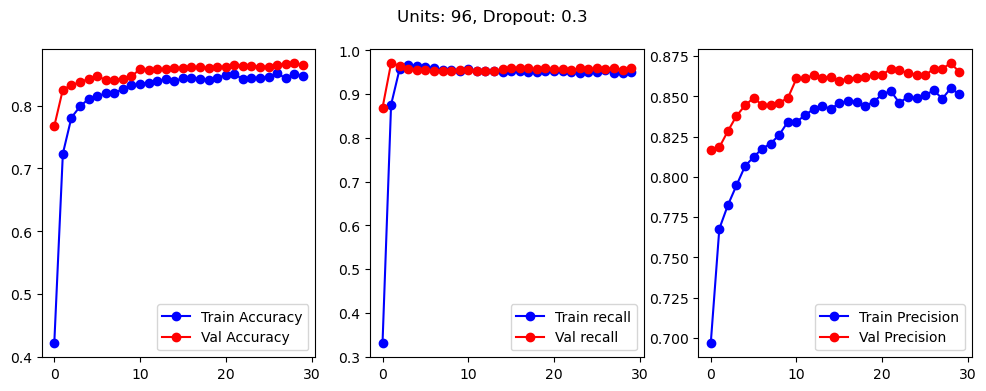

In [68]:
# historys = [hist.history for hist in hist_list]
i = 0
for units, dropout in product(units_list, dropout_list):
    plt.figure(figsize=(12,4)).suptitle(f'Units: {units}, Dropout: {dropout}')
    
    temp_df = pd.DataFrame(hist_list[i].history)
    plt.subplot(1,3,1)
    plt.plot(temp_df['accuracy'], color='b', marker = 'o', label='Train Accuracy')
    plt.plot(temp_df['val_accuracy'], color = 'r', marker = 'o', label='Val Accuracy')
    plt.legend()
    plt.subplot(1,3,2)
    col_name = 'recall_' + str(i+3)
    plt.plot(temp_df[col_name], color='b', marker = 'o', label='Train recall')
    plt.plot(temp_df['val_' + col_name], color = 'r', marker = 'o', label='Val recall')
    plt.legend()
    plt.subplot(1,3,3)
    col_name = 'precision_' + str(i+3)
    plt.plot(temp_df[col_name], color='b', marker = 'o', label='Train Precision')
    plt.plot(temp_df['val_' + col_name], color = 'r', marker = 'o', label='Val Precision')    
#     plt.title()
    plt.legend()
    i = i + 1

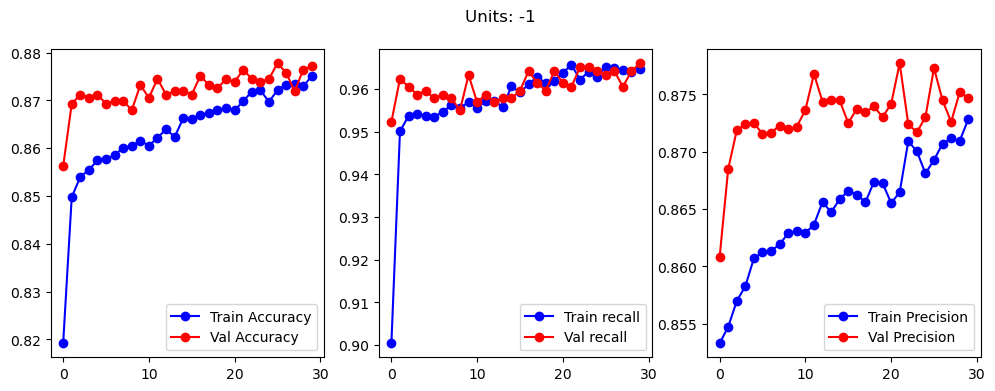

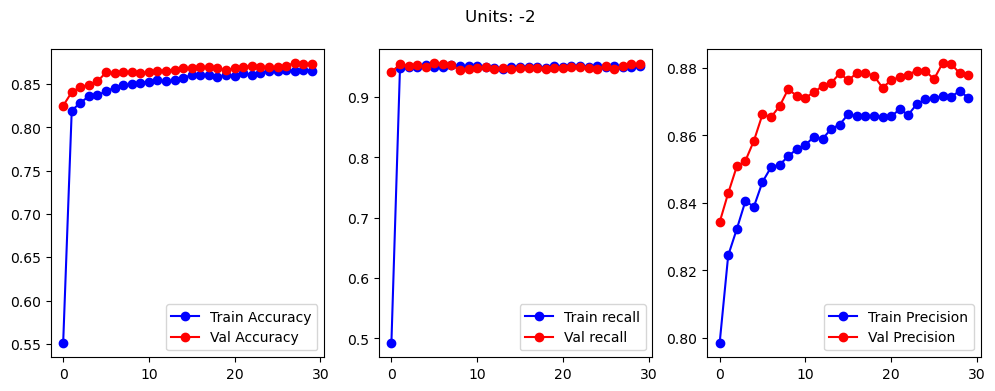

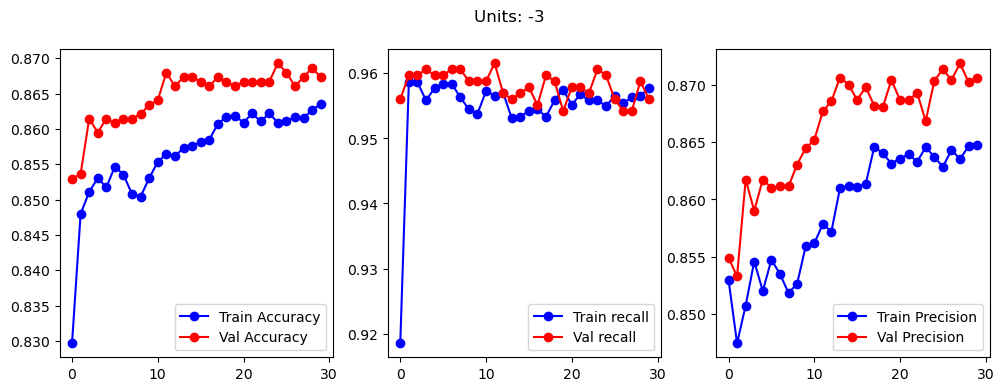

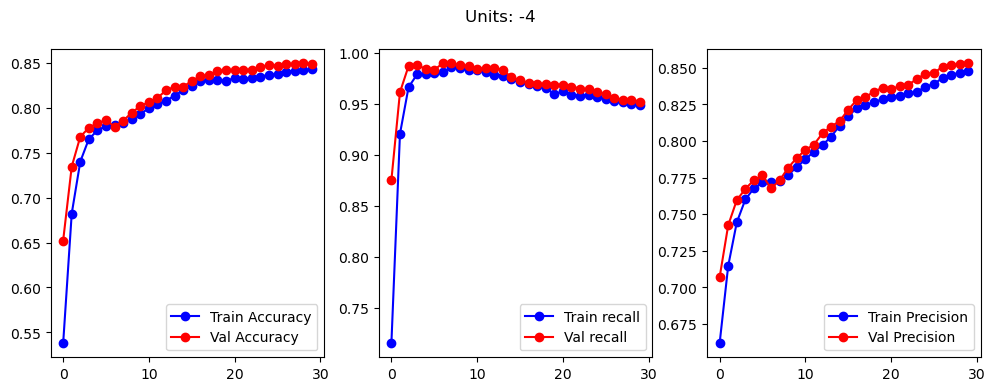

In [74]:
i = 0

for i in range(-1, -5, -1):
    plt.figure(figsize=(12,4)).suptitle(f'Units: {i}')
    
    temp_df = pd.DataFrame(hist_list[i].history)
    plt.subplot(1,3,1)
    plt.plot(temp_df['accuracy'], color='b', marker = 'o', label='Train Accuracy')
    plt.plot(temp_df['val_accuracy'], color = 'r', marker = 'o', label='Val Accuracy')
    plt.legend()
    plt.subplot(1,3,2)
    col_name = 'recall_' + str(i+13)
    plt.plot(temp_df[col_name], color='b', marker = 'o', label='Train recall')
    plt.plot(temp_df['val_' + col_name], color = 'r', marker = 'o', label='Val recall')
    plt.legend()
    plt.subplot(1,3,3)
    col_name = 'precision_' + str(i+13)
    plt.plot(temp_df[col_name], color='b', marker = 'o', label='Train Precision')
    plt.plot(temp_df['val_' + col_name], color = 'r', marker = 'o', label='Val Precision')    
#     plt.title()
    plt.legend()
#     i = i + 1

In [76]:
for units in [64, 96]:
    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights_dict = dict(zip(classes, class_weights))
    model = Sequential()
    model.add(LSTM(units=units,
                   activation='tanh',
                   input_shape=(10, 8)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate= 0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy',Recall(), Precision()])
    history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, class_weight=class_weights_dict)

    # Evaluate on Test Set
    y_pred_prob = model.predict(X_test)
    hist_list.append(history)
    y_pred_class = (y_pred_prob > 0.5).astype(int)
    report = classification_report(y_test, y_pred_class, output_dict=True, zero_division=0)
    rep_list.append(report)

Epoch 1/30
192/192 [==============================] - 110s 323ms/step - loss: 0.6483 - accuracy: 0.5331 - recall_14: 0.4214 - precision_14: 0.8431 - val_loss: 0.5909 - val_accuracy: 0.7222 - val_recall_14: 0.7067 - val_precision_14: 0.8801
Epoch 2/30
192/192 [==============================] - 33s 170ms/step - loss: 0.5380 - accuracy: 0.7595 - recall_14: 0.7644 - precision_14: 0.8814 - val_loss: 0.5053 - val_accuracy: 0.8333 - val_recall_14: 0.8818 - val_precision_14: 0.8842
Epoch 3/30
192/192 [==============================] - 33s 171ms/step - loss: 0.4942 - accuracy: 0.7952 - recall_14: 0.8263 - precision_14: 0.8782 - val_loss: 0.4787 - val_accuracy: 0.8340 - val_recall_14: 0.8781 - val_precision_14: 0.8879
Epoch 4/30
192/192 [==============================] - 32s 170ms/step - loss: 0.4774 - accuracy: 0.8171 - recall_14: 0.8588 - precision_14: 0.8808 - val_loss: 0.4626 - val_accuracy: 0.8418 - val_recall_14: 0.8882 - val_precision_14: 0.8898
Epoch 5/30
192/192 [=======================

Epoch 5/30
192/192 [==============================] - 34s 176ms/step - loss: 0.4510 - accuracy: 0.8331 - recall_15: 0.8907 - precision_15: 0.8764 - val_loss: 0.4188 - val_accuracy: 0.8516 - val_recall_15: 0.9083 - val_precision_15: 0.8864
Epoch 6/30
192/192 [==============================] - 33s 172ms/step - loss: 0.4410 - accuracy: 0.8406 - recall_15: 0.8986 - precision_15: 0.8797 - val_loss: 0.4191 - val_accuracy: 0.8477 - val_recall_15: 0.9065 - val_precision_15: 0.8830
Epoch 7/30
192/192 [==============================] - 33s 173ms/step - loss: 0.4350 - accuracy: 0.8418 - recall_15: 0.9015 - precision_15: 0.8789 - val_loss: 0.4090 - val_accuracy: 0.8549 - val_recall_15: 0.9120 - val_precision_15: 0.8876
Epoch 8/30
192/192 [==============================] - 33s 171ms/step - loss: 0.4301 - accuracy: 0.8432 - recall_15: 0.9004 - precision_15: 0.8815 - val_loss: 0.3967 - val_accuracy: 0.8601 - val_recall_15: 0.9221 - val_precision_15: 0.8863
Epoch 9/30
192/192 [========================

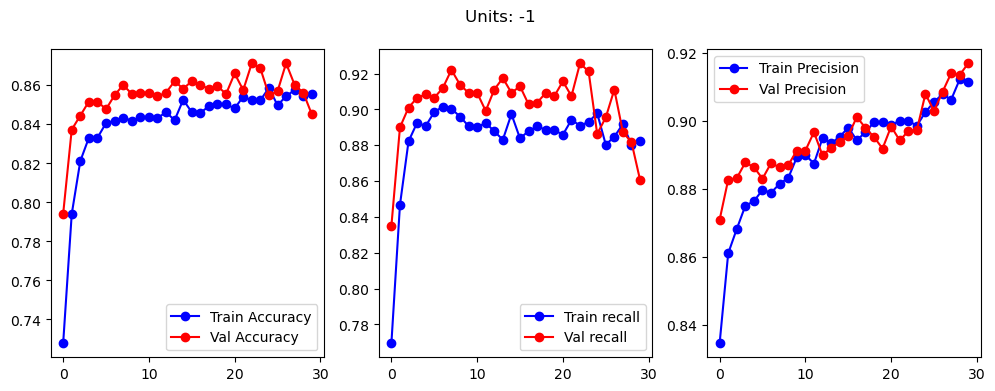

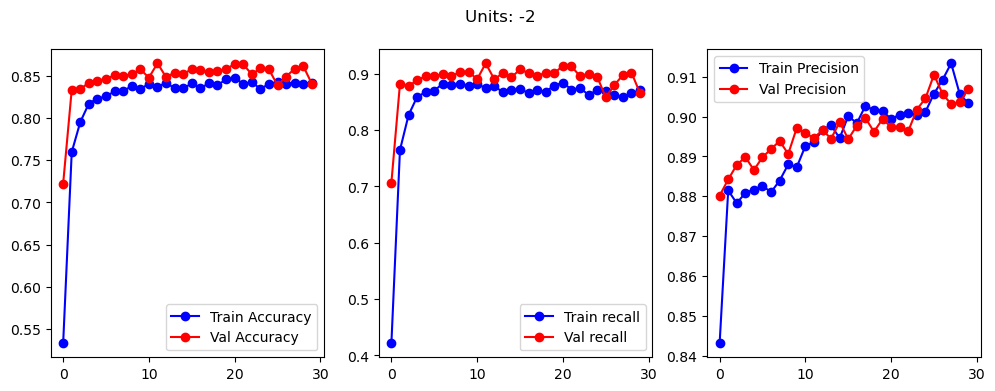

In [81]:
for i in range(-1, -3, -1):
    plt.figure(figsize=(12,4)).suptitle(f'Units: {i}')
    
    temp_df = pd.DataFrame(hist_list[i].history)
    plt.subplot(1,3,1)
    plt.plot(temp_df['accuracy'], color='b', marker = 'o', label='Train Accuracy')
    plt.plot(temp_df['val_accuracy'], color = 'r', marker = 'o', label='Val Accuracy')
    plt.legend()
    plt.subplot(1,3,2)
    col_name = 'recall_' + str(i+16)
    plt.plot(temp_df[col_name], color='b', marker = 'o', label='Train recall')
    plt.plot(temp_df['val_' + col_name], color = 'r', marker = 'o', label='Val recall')
    plt.legend()
    plt.subplot(1,3,3)
    col_name = 'precision_' + str(i+16)
    plt.plot(temp_df[col_name], color='b', marker = 'o', label='Train Precision')
    plt.plot(temp_df['val_' + col_name], color = 'r', marker = 'o', label='Val Precision')    
#     plt.title()
    plt.legend()

In [11]:
hist_list = []
for units in [64]:
    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights_dict = dict(zip(classes, class_weights))
    model = Sequential()
    model.add(LSTM(units=units,
                   activation='tanh', return_sequences=True,
                   input_shape=(10, 8)))
    model.add(Dropout(0.3))
    model.add(LSTM(32)),
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate= 0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy',Recall(), Precision()])
    history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, class_weight=class_weights_dict)
#     model.save("lstm_model_best_recall_50ep.h5")
    # Evaluate on Test Set
    y_pred_prob = model.predict(X_test)
    hist_list.append(history)
    y_pred_class = (y_pred_prob > 0.5).astype(int)
    report = classification_report(y_test, y_pred_class, output_dict=True, zero_division=0)
    rep_list.append(report)

Epoch 1/50
192/192 [==============================] - 16s 29ms/step - loss: 0.6240 - accuracy: 0.6941 - recall_4: 0.7244 - precision_4: 0.8239 - val_loss: 0.4944 - val_accuracy: 0.8268 - val_recall_4: 0.8928 - val_precision_4: 0.8681
Epoch 2/50
192/192 [==============================] - 4s 23ms/step - loss: 0.4848 - accuracy: 0.8249 - recall_4: 0.8907 - precision_4: 0.8666 - val_loss: 0.3946 - val_accuracy: 0.8477 - val_recall_4: 0.9010 - val_precision_4: 0.8872
Epoch 3/50
192/192 [==============================] - 3s 18ms/step - loss: 0.4080 - accuracy: 0.8346 - recall_4: 0.8686 - precision_4: 0.8954 - val_loss: 0.3637 - val_accuracy: 0.8477 - val_recall_4: 0.8579 - val_precision_4: 0.9231
Epoch 4/50
192/192 [==============================] - 3s 18ms/step - loss: 0.3785 - accuracy: 0.8298 - recall_4: 0.8378 - precision_4: 0.9155 - val_loss: 0.3478 - val_accuracy: 0.8405 - val_recall_4: 0.8414 - val_precision_4: 0.9282
Epoch 5/50
192/192 [==============================] - 4s 19ms/step 

192/192 [==============================] - 5s 25ms/step - loss: 0.2824 - accuracy: 0.8767 - recall_4: 0.8808 - precision_4: 0.9419 - val_loss: 0.2638 - val_accuracy: 0.8915 - val_recall_4: 0.8937 - val_precision_4: 0.9512
Epoch 37/50
192/192 [==============================] - 3s 18ms/step - loss: 0.2733 - accuracy: 0.8834 - recall_4: 0.8838 - precision_4: 0.9486 - val_loss: 0.2667 - val_accuracy: 0.8810 - val_recall_4: 0.8854 - val_precision_4: 0.9443
Epoch 38/50
192/192 [==============================] - 4s 19ms/step - loss: 0.2674 - accuracy: 0.8880 - recall_4: 0.8946 - precision_4: 0.9448 - val_loss: 0.2618 - val_accuracy: 0.8837 - val_recall_4: 0.8854 - val_precision_4: 0.9480
Epoch 39/50
192/192 [==============================] - 5s 24ms/step - loss: 0.2688 - accuracy: 0.8859 - recall_4: 0.8910 - precision_4: 0.9453 - val_loss: 0.2590 - val_accuracy: 0.8948 - val_recall_4: 0.8973 - val_precision_4: 0.9523
Epoch 40/50
192/192 [==============================] - 4s 19ms/step - loss: 

NameError: name 'rep_list' is not defined

In [13]:
report

{'0': {'precision': 0.7917933130699089,
  'recall': 0.8875638841567292,
  'f1-score': 0.8369477911646587,
  'support': 587},
 '1': {'precision': 0.9473684210526315,
  'recall': 0.8966037735849056,
  'f1-score': 0.9212873206669251,
  'support': 1325},
 'accuracy': 0.8938284518828452,
 'macro avg': {'precision': 0.8695808670612701,
  'recall': 0.8920838288708174,
  'f1-score': 0.8791175559157919,
  'support': 1912},
 'weighted avg': {'precision': 0.8996055610181869,
  'recall': 0.8938284518828452,
  'f1-score': 0.895394379339608,
  'support': 1912}}

In [14]:
y_pred_prob = model.predict(X_test)

# Threshold Tuning
best_thresh = 0.5
best_recall = 0
best_report = None
best_preds = None

print("\nTuning Threshold to Maximize Recall for Class 1:\n")
for thresh in np.arange(0.1, 0.6, 0.05):
    y_pred_class = (y_pred_prob > thresh).astype(int)
    report = classification_report(y_test, y_pred_class, output_dict=True, zero_division=0)

    recall = report.get('1', {}).get('recall', 0)
    precision = report.get('1', {}).get('precision', 0)

    print(f"Threshold: {thresh:.2f} | Recall: {recall:.4f} | Precision: {precision:.4f}")

    if recall > best_recall:
        best_recall = recall
        best_thresh = thresh
        best_report = report
        best_preds = y_pred_class

# Print Best Threshold Report
print(f"\nBest Threshold = {best_thresh:.2f} with Recall = {best_recall:.4f}\n")
print(classification_report(y_test, best_preds))

60/60 [==============================] - 1s 7ms/step

Tuning Threshold to Maximize Recall for Class 1:

Threshold: 0.10 | Recall: 0.9849 | Precision: 0.8660
Threshold: 0.15 | Recall: 0.9781 | Precision: 0.8871
Threshold: 0.20 | Recall: 0.9698 | Precision: 0.9030
Threshold: 0.25 | Recall: 0.9608 | Precision: 0.9106
Threshold: 0.30 | Recall: 0.9517 | Precision: 0.9184
Threshold: 0.35 | Recall: 0.9358 | Precision: 0.9261
Threshold: 0.40 | Recall: 0.9230 | Precision: 0.9386
Threshold: 0.45 | Recall: 0.9087 | Precision: 0.9443
Threshold: 0.50 | Recall: 0.8966 | Precision: 0.9474
Threshold: 0.55 | Recall: 0.8747 | Precision: 0.9508

Best Threshold = 0.10 with Recall = 0.9849

              precision    recall  f1-score   support

           0       0.95      0.66      0.78       587
           1       0.87      0.98      0.92      1325

    accuracy                           0.88      1912
   macro avg       0.91      0.82      0.85      1912
weighted avg       0.89      0.88      0.88      

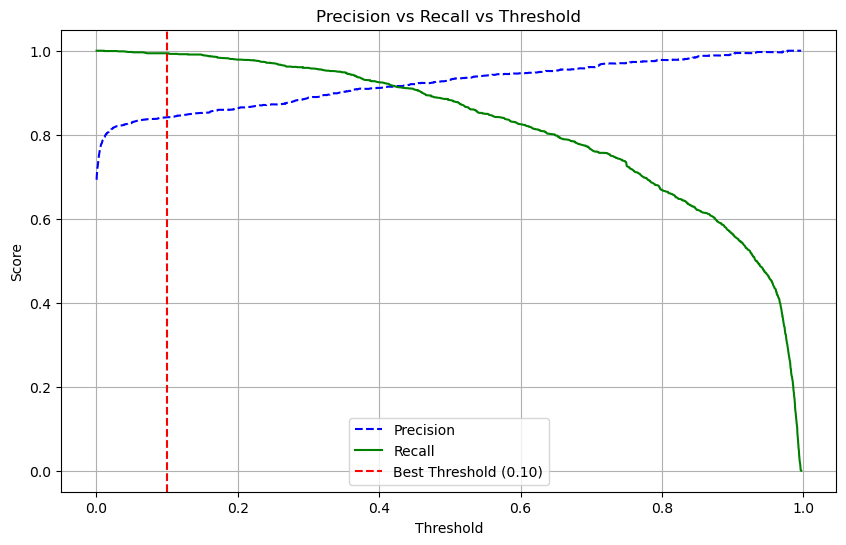

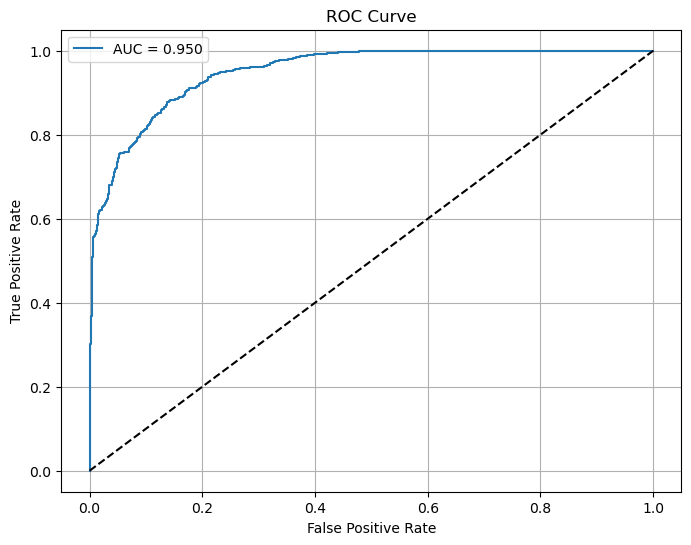

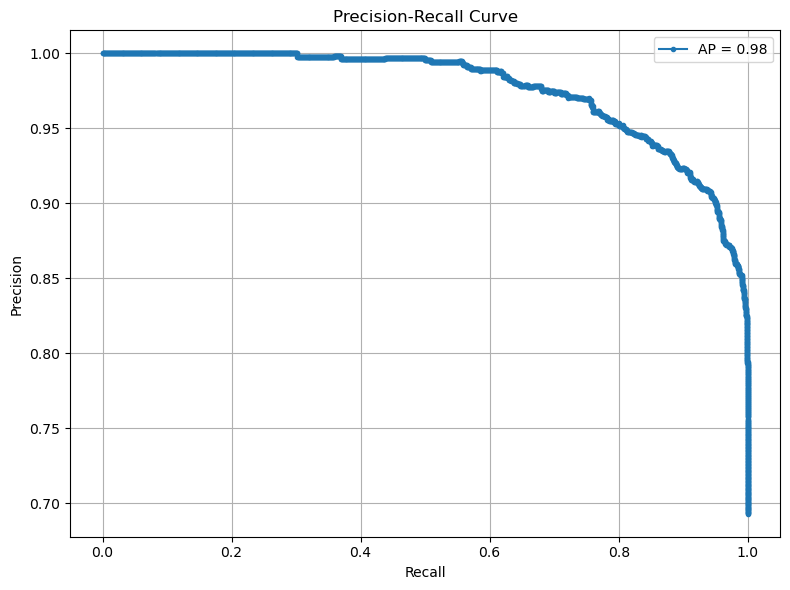

In [91]:
plot_precision_recall_vs_threshold(y_test, y_pred_prob)
plot_roc(y_test, y_pred_prob)
plot_pr_curve(y_test, y_pred_prob)

<Axes: >

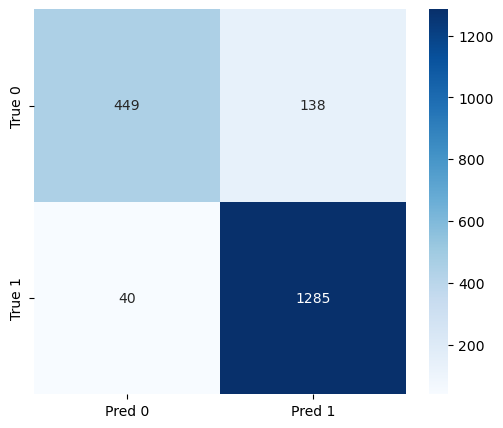

In [17]:
y_pred_class = (y_pred_prob > 0.2).astype(int)
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(6, 5))
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred 0', 'Pred 1'], 
            yticklabels=['True 0', 'True 1'])

In [18]:
# Final Model as mentioned in paper
# Best Threshold 0.2
model.save("lstm_model_best_recall_50ep.h5")


In [ ]:
# def plot_f1score_vs_threshold(y_true, y_prob):
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_prob)
    

In [93]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
model = Sequential()
model.add(LSTM(units=64,
               activation='tanh', 
               input_shape=(10, 8)))
model.add(Dropout(0.3))
# model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate= 0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy',Recall(), Precision()])
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, class_weight=class_weights_dict)

# Evaluate on Test Set
y_pred_prob = model.predict(X_test)
hist_list.append(history)
y_pred_class = (y_pred_prob > 0.5).astype(int)
report = classification_report(y_test, y_pred_class, output_dict=True, zero_division=0)
rep_list.append(report)

y_pred_prob = model.predict(X_test)

# Threshold Tuning
best_thresh = 0.5
best_recall = 0
best_report = None
best_preds = None

print("\nTuning Threshold to Maximize Recall for Class 1:\n")
for thresh in np.arange(0.1, 0.6, 0.05):
    y_pred_class = (y_pred_prob > thresh).astype(int)
    report = classification_report(y_test, y_pred_class, output_dict=True, zero_division=0)

    recall = report.get('1', {}).get('recall', 0)
    precision = report.get('1', {}).get('precision', 0)

    print(f"Threshold: {thresh:.2f} | Recall: {recall:.4f} | Precision: {precision:.4f}")

    if recall > best_recall:
        best_recall = recall
        best_thresh = thresh
        best_report = report
        best_preds = y_pred_class

# Print Best Threshold Report
print(f"\nBest Threshold = {best_thresh:.2f} with Recall = {best_recall:.4f}\n")
print(classification_report(y_test, best_preds))

Epoch 1/50
192/192 [==============================] - 96s 292ms/step - loss: 0.6138 - accuracy: 0.7558 - recall_18: 0.8445 - precision_18: 0.8178 - val_loss: 0.5299 - val_accuracy: 0.8458 - val_recall_18: 0.9166 - val_precision_18: 0.8734
Epoch 2/50
192/192 [==============================] - 31s 160ms/step - loss: 0.5482 - accuracy: 0.7773 - recall_18: 0.8208 - precision_18: 0.8596 - val_loss: 0.5044 - val_accuracy: 0.8477 - val_recall_18: 0.9102 - val_precision_18: 0.8803
Epoch 3/50
192/192 [==============================] - 31s 163ms/step - loss: 0.5178 - accuracy: 0.7922 - recall_18: 0.8371 - precision_18: 0.8660 - val_loss: 0.4836 - val_accuracy: 0.8536 - val_recall_18: 0.9120 - val_precision_18: 0.8860
Epoch 4/50
192/192 [==============================] - 30s 159ms/step - loss: 0.4921 - accuracy: 0.8123 - recall_18: 0.8645 - precision_18: 0.8705 - val_loss: 0.4684 - val_accuracy: 0.8529 - val_recall_18: 0.9111 - val_precision_18: 0.8859
Epoch 5/50
192/192 [========================

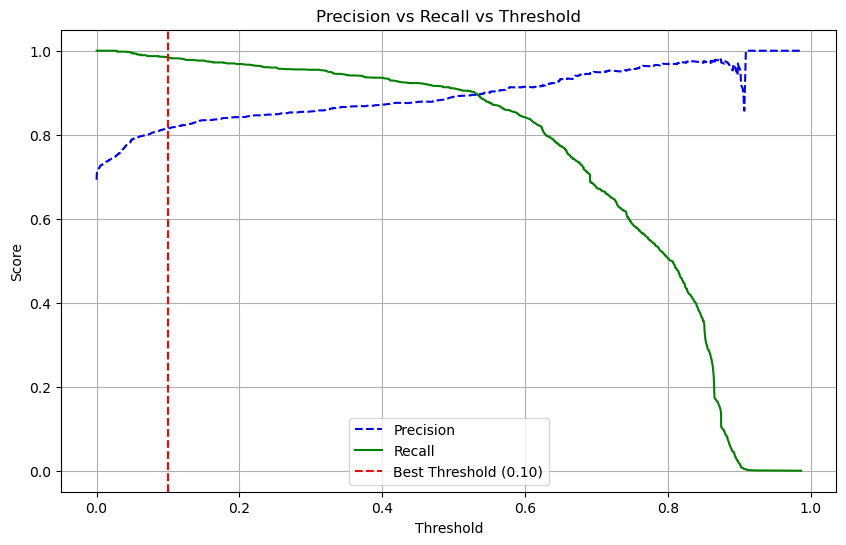

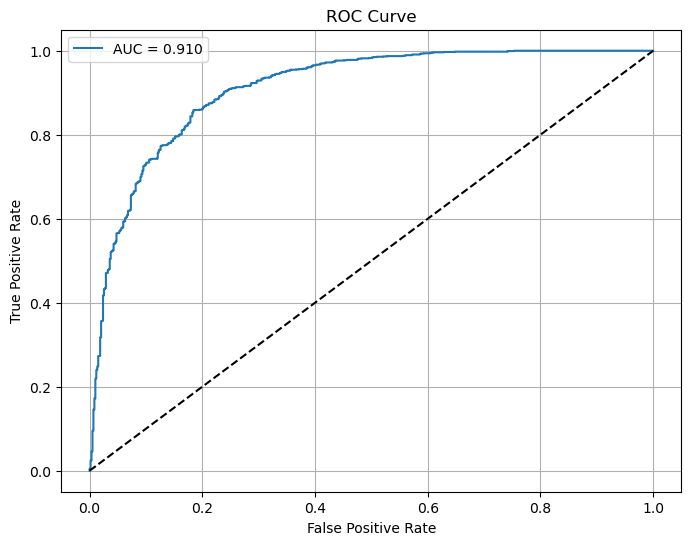

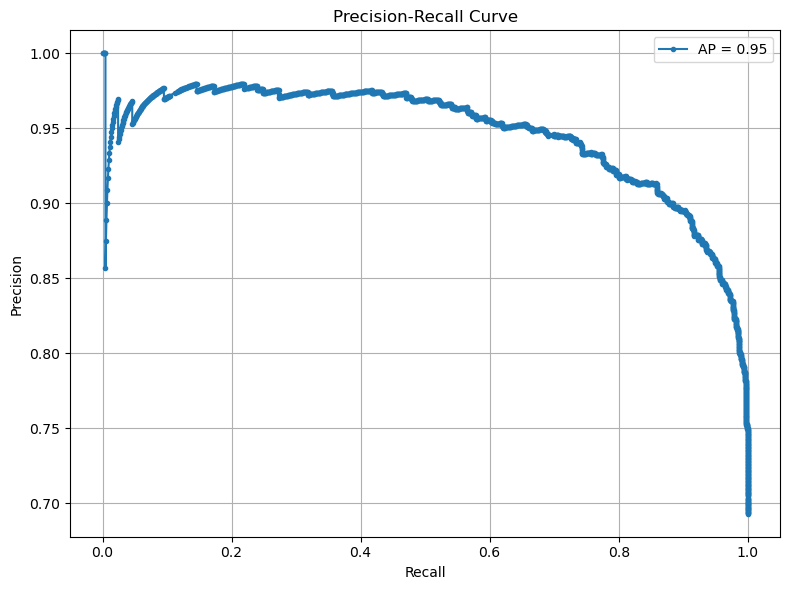

In [94]:
plot_precision_recall_vs_threshold(y_test, y_pred_prob)
plot_roc(y_test, y_pred_prob)
plot_pr_curve(y_test, y_pred_prob)

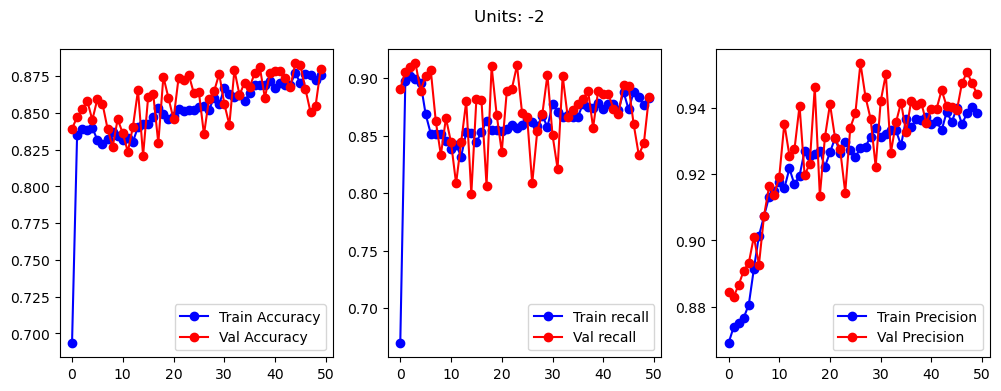

In [100]:
for i in range(-2, -3, -1):
    plt.figure(figsize=(12,4)).suptitle(f'Units: {i}')
    
    temp_df = pd.DataFrame(hist_list[i].history)
    plt.subplot(1,3,1)
    plt.plot(temp_df['accuracy'], color='b', marker = 'o', label='Train Accuracy')
    plt.plot(temp_df['val_accuracy'], color = 'r', marker = 'o', label='Val Accuracy')
    plt.legend()
    plt.subplot(1,3,2)
    col_name = 'recall_' + str(16)
    plt.plot(temp_df[col_name], color='b', marker = 'o', label='Train recall')
    plt.plot(temp_df['val_' + col_name], color = 'r', marker = 'o', label='Val recall')
    plt.legend()
    plt.subplot(1,3,3)
    col_name = 'precision_' + str(16)
    plt.plot(temp_df[col_name], color='b', marker = 'o', label='Train Precision')
    plt.plot(temp_df['val_' + col_name], color = 'r', marker = 'o', label='Val Precision')    
#     plt.title()
    plt.legend()

In [99]:
hist_list[-2].history

{'loss': [0.6006228923797607,
  0.47510015964508057,
  0.44556546211242676,
  0.42832547426223755,
  0.41589224338531494,
  0.4007473289966583,
  0.3874857723712921,
  0.3821670711040497,
  0.36756208539009094,
  0.36323845386505127,
  0.36178672313690186,
  0.3541673421859741,
  0.3498397767543793,
  0.34859412908554077,
  0.3463532030582428,
  0.3366352915763855,
  0.33805012702941895,
  0.3343605101108551,
  0.3316717743873596,
  0.33300745487213135,
  0.3318459093570709,
  0.32598745822906494,
  0.32515403628349304,
  0.3208145201206207,
  0.31919899582862854,
  0.3207676112651825,
  0.3111843764781952,
  0.3141542971134186,
  0.3142740726470947,
  0.31031283736228943,
  0.3020085096359253,
  0.31161707639694214,
  0.30681827664375305,
  0.3033687472343445,
  0.3038441240787506,
  0.30321604013442993,
  0.3012489378452301,
  0.29574158787727356,
  0.2919902801513672,
  0.2942795157432556,
  0.29502081871032715,
  0.2957090437412262,
  0.2931777536869049,
  0.2910957336425781,
  0.2

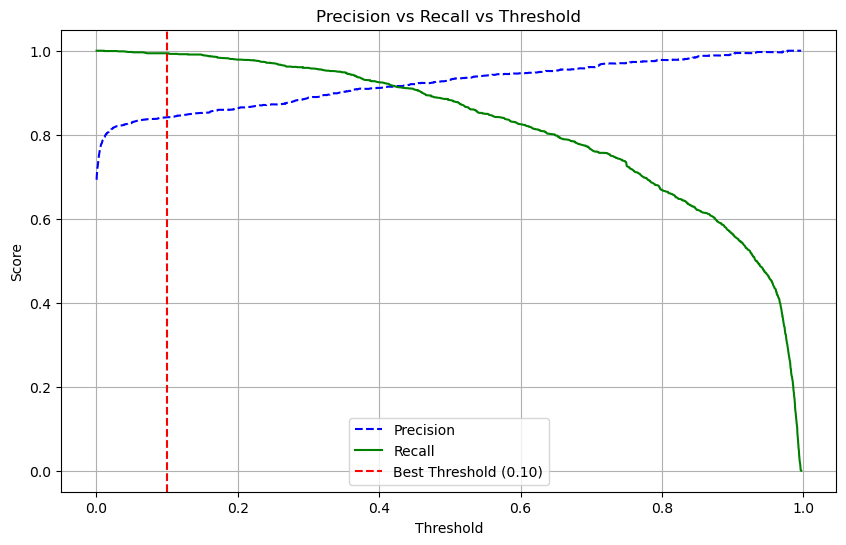

In [86]:
from sklearn.metrics import precision_recall_curve
def plot_precision_recall_vs_threshold(y_true, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.axvline(x=0.10, color='r', linestyle='--', label='Best Threshold (0.10)')
    plt.title('Precision vs Recall vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.show()



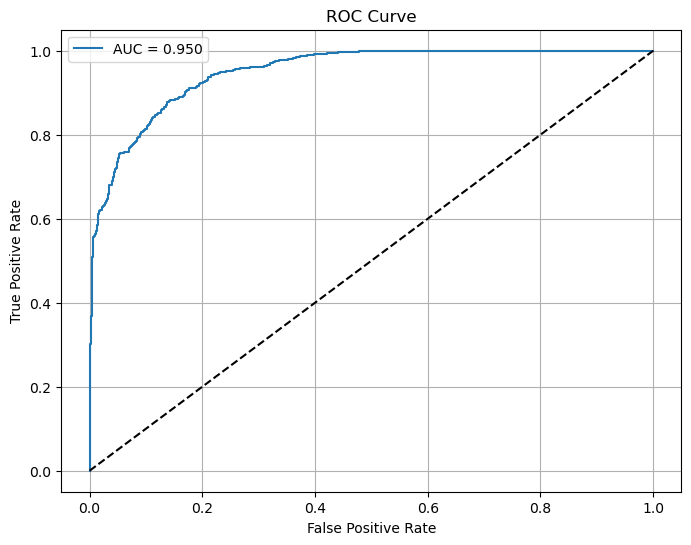

In [87]:
def plot_roc(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()



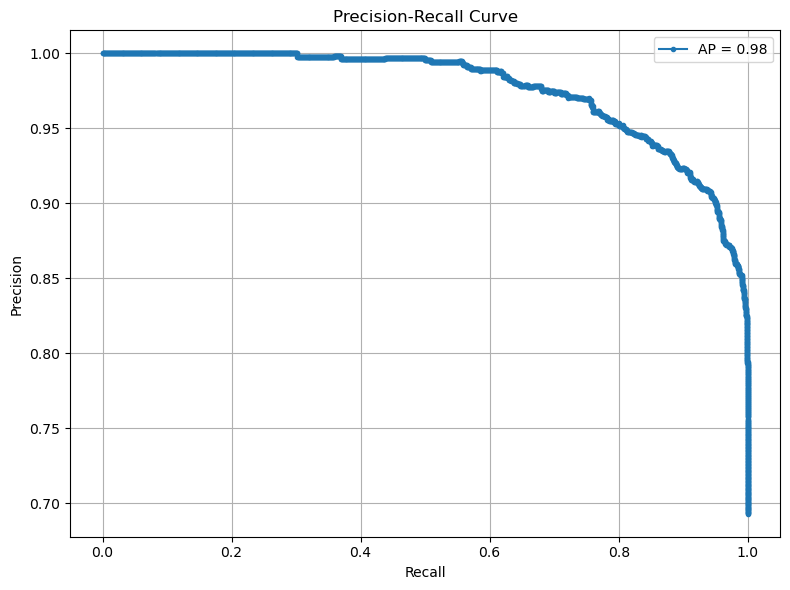

In [90]:
from sklearn.metrics import precision_recall_curve, average_precision_score
def plot_pr_curve(y_true, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    ap_score = average_precision_score(y_true, y_prob)

    # Plot the curve
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='.', label=f'AP = {ap_score:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [33]:
from tensorflow.keras.callbacks import Callback
class ResultLogger(Callback):
    def __init__(self):
        self.trial_results = []

    def on_trial_end(self, trial):
        # Save metrics and hyperparameters at end of trial
        self.trial_results.append({
            'trial_id': trial.trial_id,
            **trial.hyperparameters.values,
            **trial.metrics.get_last_value_dict()
        })

In [ ]:
tuner.results_summary()

In [19]:
df_lstm = pd.read_csv(r"F:\Work\Misc\Mentees\SodiumDisposal\combined_data_grouped_with_padding_flag.csv")
df_lstm.head()

,exp,video,segment,frame,n_masks,n_masks^3,mask_area,mask_centroid,mask_conf,mask_strength,...,avg_mask_area,avg_bbox_area,avg_mask_strength,avg_bbox_width,avg_bbox_height,mask_centroid_dist,bbox_centroid_dist,Label,label_LSTM,is_padding
0,04_07_2024,2024-07-04_11_51_08_772,2,100,1.0,1.0,[48],"[[277.0, 155.0]]",[0.38094273],[199.52],...,48.0,56.0,199.520,8.0,8.0,0.00,0.00,0,0,0
1,04_07_2024,2024-07-04_11_51_08_772,2,101,0.0,0.0,[],[],[],[],...,0.0,0.0,0.000,0.0,0.0,0.00,0.00,0,0,0
2,04_07_2024,2024-07-04_11_51_08_772,2,102,0.0,0.0,[],[],[],[],...,0.0,0.0,0.000,0.0,0.0,0.00,0.00,0,0,0
3,04_07_2024,2024-07-04_11_51_08_772,2,103,2.0,8.0,"[118, 198]","[[282.0, 164.0], [281.0, 162.0]]","[0.58505154, 0.40290353]","[198.36, 198.99]",...,158.0,183.0,198.675,10.5,10.5,2.24,2.24,0,0,0
4,04_07_2024,2024-07-04_11_51_08_772,2,104,2.0,8.0,"[118, 198]","[[282.0, 164.0], [281.0, 162.0]]","[0.5849741, 0.40308228]","[198.36, 198.99]",...,158.0,183.0,198.675,10.5,10.5,2.24,2.24,0,0,0


In [20]:
def count_runs(seq, value):
    counts = []
    count = 0
    for v in seq:
        if v == value:
            count += 1
        else:
            if count > 0:
                counts.append(count)
                count = 0
    if count > 0:
        counts.append(count)
    return counts

# Count continuous 0s and 1s
zeros_runs = count_runs(df_lstm['Label'], 0)
ones_runs = count_runs(df_lstm['Label'], 1)

(array([25.,  8.,  6.,  3.,  5.,  2.,  1.,  0.,  0.,  1.]),
 array([   2. ,  171.1,  340.2,  509.3,  678.4,  847.5, 1016.6, 1185.7,
        1354.8, 1523.9, 1693. ]),
 <BarContainer object of 10 artists>)

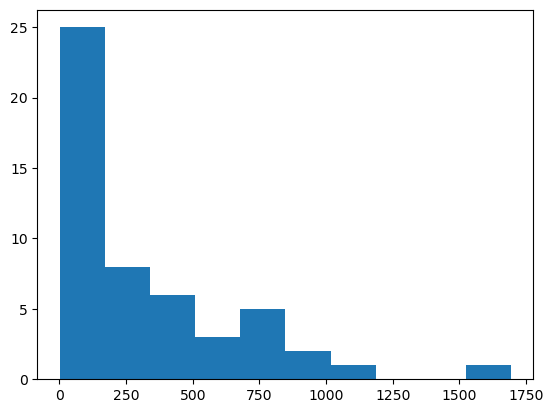

In [22]:
plt.hist(zeros_runs)

(array([41.,  3.,  2.,  0.,  0.,  0.,  1.,  1.,  0.,  2.]),
 array([   3. ,  138.2,  273.4,  408.6,  543.8,  679. ,  814.2,  949.4,
        1084.6, 1219.8, 1355. ]),
 <BarContainer object of 10 artists>)

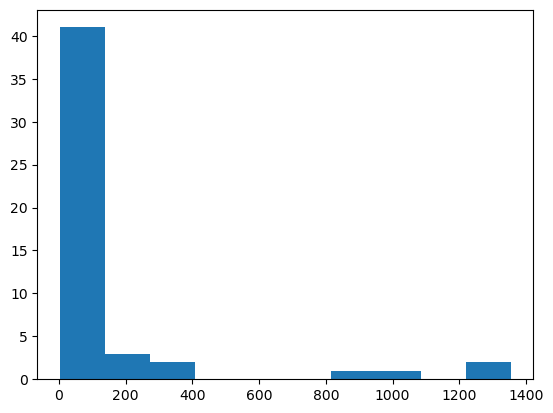

In [23]:
plt.hist(ones_runs)

### Plot Training Validation And Accuracy

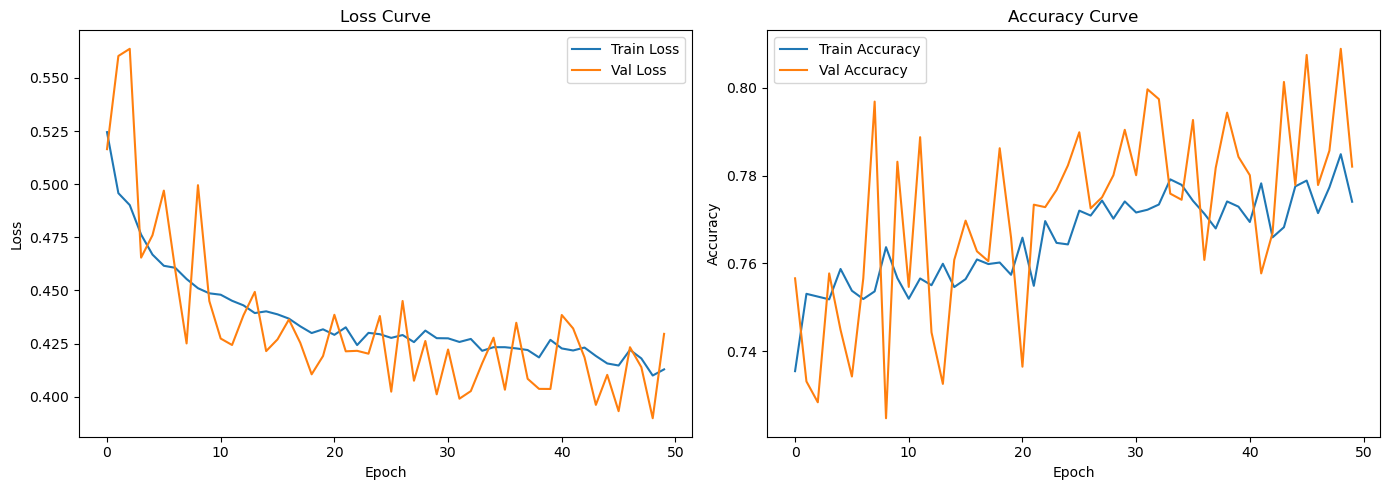

In [11]:
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Val Loss')
    axs[0].set_title('Loss Curve')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axs[1].set_title('Accuracy Curve')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

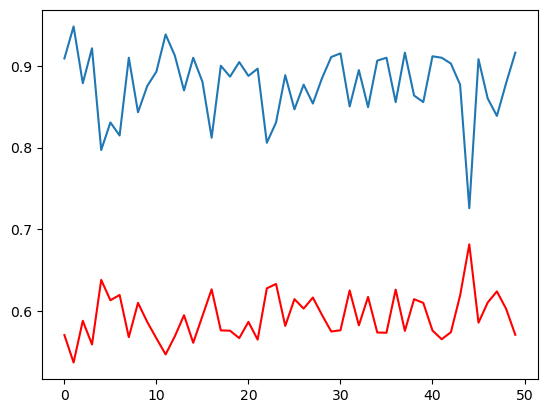

In [16]:
plt.plot(history.history['val_recall_1'])
plt.plot(history.history['val_precision_1'], color='r')

### Precision, Recall, Threshold

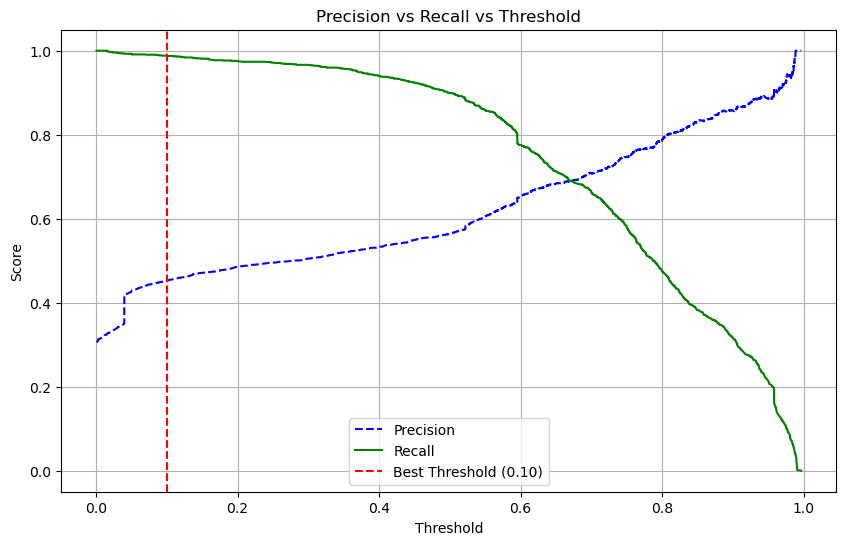

In [17]:
from sklearn.metrics import precision_recall_curve
def plot_precision_recall_vs_threshold(y_true, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.axvline(x=0.10, color='r', linestyle='--', label='Best Threshold (0.10)')
    plt.title('Precision vs Recall vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.show()

plot_precision_recall_vs_threshold(y_test, y_pred_prob)

### ROC

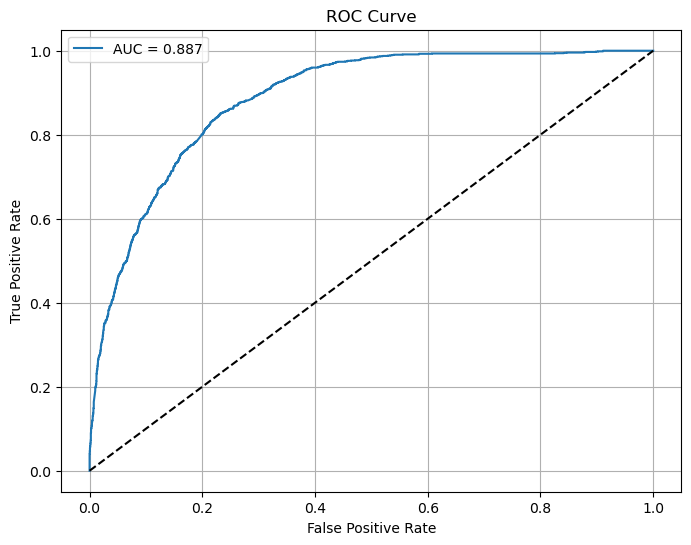

In [20]:
def plot_roc(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

plot_roc(y_test, y_pred_prob)

### Confusion Matrix (Thresold = 0.1)

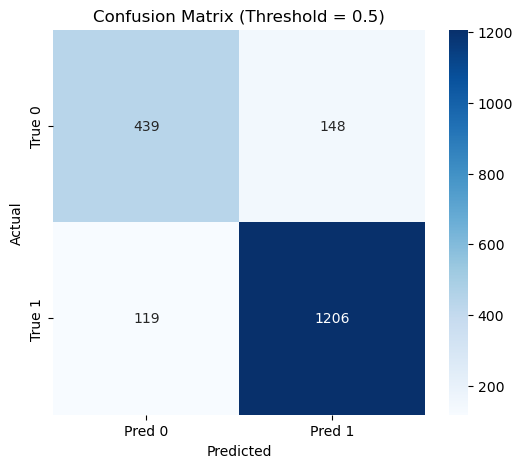

In [101]:
import seaborn as sns
def plot_confusion_matrix(y_true, y_prob, threshold=0.50):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Pred 0', 'Pred 1'], 
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix (Threshold = {threshold})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_test, y_pred_prob, threshold=0.50)

### Confusion Matrix (All threshold)

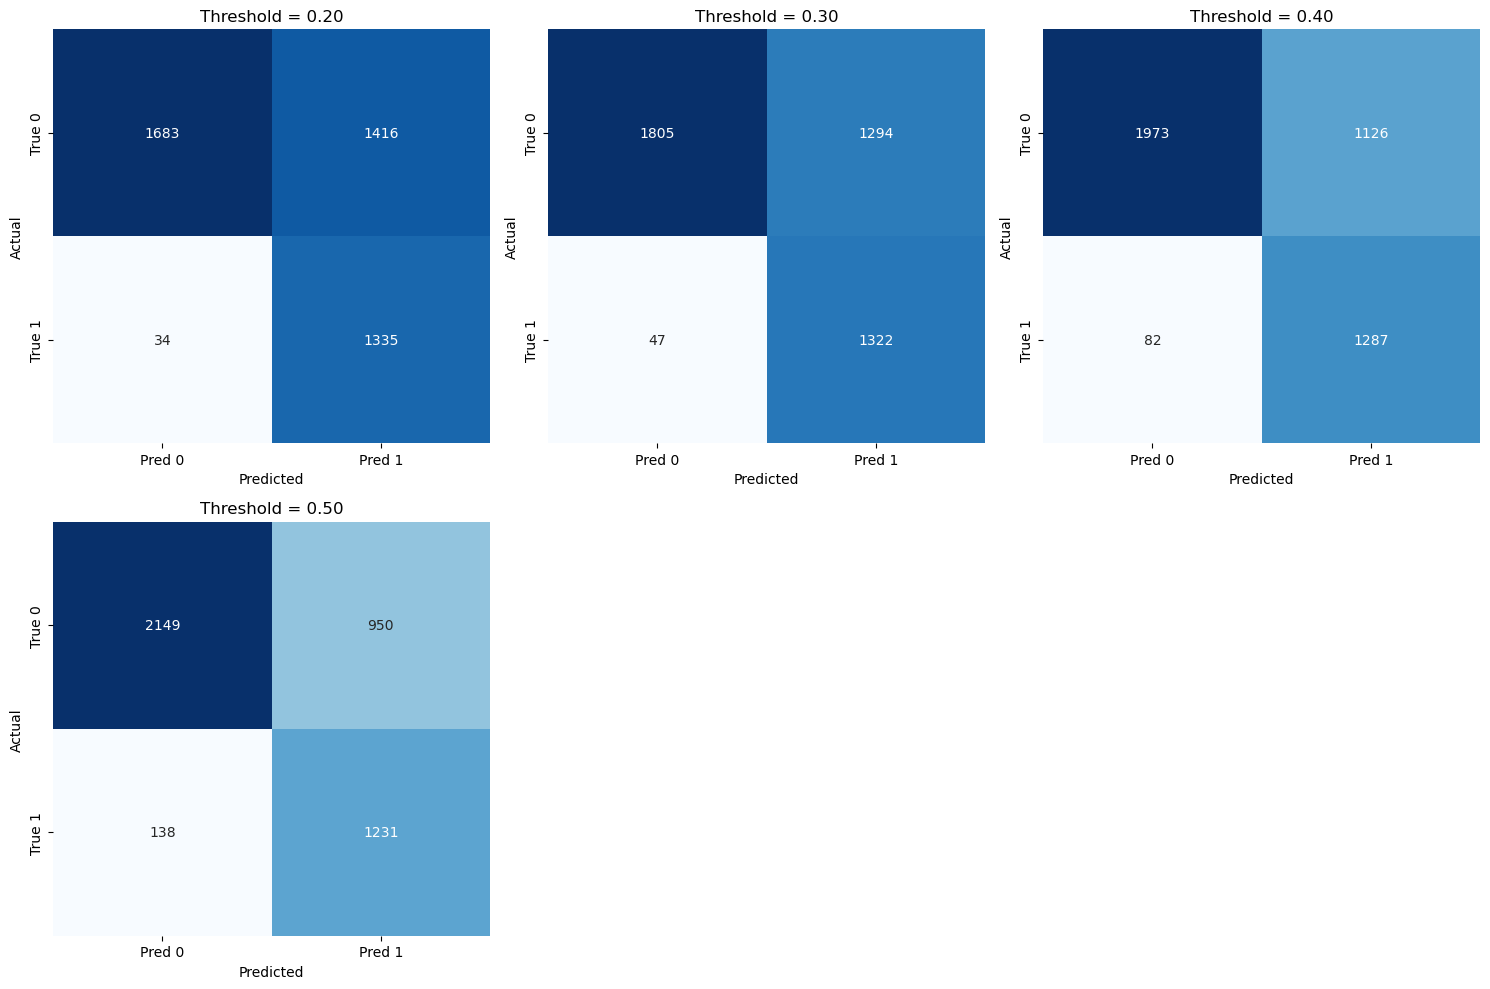

In [22]:
thresholds_to_plot = [0.2, 0.3, 0.4, 0.5]

plt.figure(figsize=(15, 10))

for i, thresh in enumerate(thresholds_to_plot):
    y_pred_class = (y_pred_prob > thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_class)
    plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(f"Threshold = {thresh:.2f}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

### Feature Importance

140/140 [==============================] - 0s 3ms/step


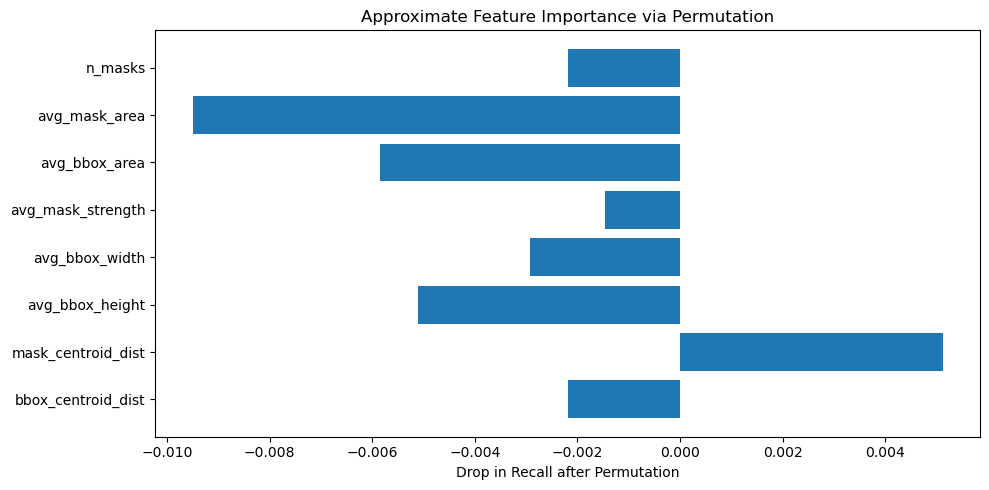

In [23]:
from sklearn.metrics import recall_score
import numpy as np

baseline_preds = (model.predict(X_test) > best_thresh).astype(int)
baseline_score = recall_score(y_test, baseline_preds)

importances = []

for i, col in enumerate(feature_cols):
    X_test_permuted = X_test.copy()
    np.random.shuffle(X_test_permuted[:, :, i])

    permuted_preds = (model.predict(X_test_permuted) > best_thresh).astype(int)
    permuted_score = recall_score(y_test, permuted_preds)

    importance = baseline_score - permuted_score
    importances.append(importance)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(feature_cols, importances)
plt.xlabel("Drop in Recall after Permutation")
plt.title("Approximate Feature Importance via Permutation")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# EDA - Extracted Features

In [5]:
import matplotlib.pyplot as plt
df_lstm = pd.read_csv(r"F:\Work\Misc\Mentees\SodiumDisposal\combined_data_grouped_with_padding_flag_Modified.csv")
print(df_lstm['is_padding'].value_counts())
# df_lstm.drop(cols_drop_lstm, axis=1, inplace=True)

numeric_cols = df_lstm[df_lstm.columns].select_dtypes(include='number').columns
feature_cols = [col for col in df_lstm.columns if col not in ['label_LSTM', 'is_padding']]
df_lstm.head()

0    10047
1       55
Name: is_padding, dtype: int64


,exp,video,segment,frame,n_masks,n_masks^3,mask_area,mask_centroid,mask_conf,mask_strength,...,avg_mask_area,avg_bbox_area,avg_mask_strength,avg_bbox_width,avg_bbox_height,mask_centroid_dist,bbox_centroid_dist,Label,label_LSTM,is_padding
0,04_07_2024,2024-07-04_11_51_08_772,2,103,2,8.0,"[118, 198]","[[282.0, 164.0], [281.0, 162.0]]","[0.58505154, 0.40290353]","[198.36, 198.99]",...,158.0,183.0,198.675,10.5,10.5,2.24,2.24,0,0,0
1,04_07_2024,2024-07-04_11_51_08_772,2,104,2,8.0,"[118, 198]","[[282.0, 164.0], [281.0, 162.0]]","[0.5849741, 0.40308228]","[198.36, 198.99]",...,158.0,183.0,198.675,10.5,10.5,2.24,2.24,0,0,0
2,04_07_2024,2024-07-04_11_51_08_772,2,105,2,8.0,"[130, 208]","[[281.0, 164.0], [280.0, 161.0]]","[0.5417702, 0.39804193]","[200.38, 200.33]",...,169.0,205.0,200.355,11.5,11.5,3.16,3.61,0,0,0
3,04_07_2024,2024-07-04_11_51_08_772,2,106,2,8.0,"[130, 208]","[[281.0, 164.0], [280.0, 161.0]]","[0.54170984, 0.39807338]","[200.38, 200.33]",...,169.0,205.0,200.355,11.5,11.5,3.16,3.61,0,0,0
4,04_07_2024,2024-07-04_11_51_08_772,2,107,2,8.0,"[73, 175]","[[281.0, 164.0], [279.0, 160.0]]","[0.53110915, 0.3922359]","[192.42, 195.35]",...,124.0,164.0,193.885,10.0,10.0,4.47,4.47,0,0,0


<Axes: xlabel='n_masks', ylabel='Count'>

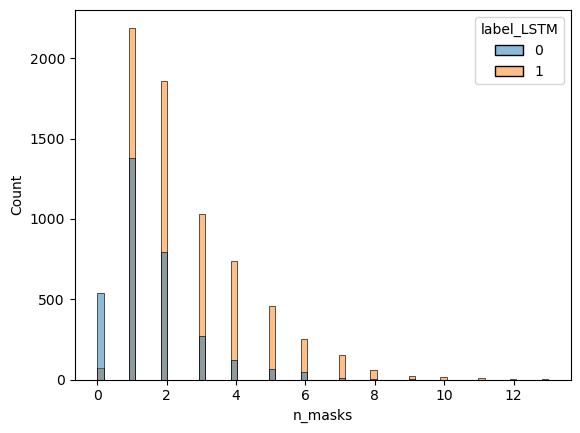

In [6]:
import seaborn as sns
sns.histplot(data = df_lstm, x = 'n_masks', hue='label_LSTM')

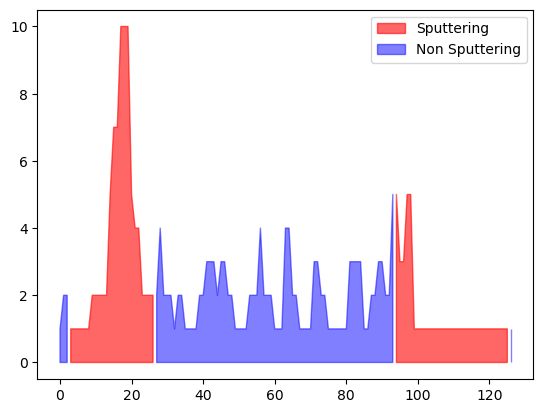

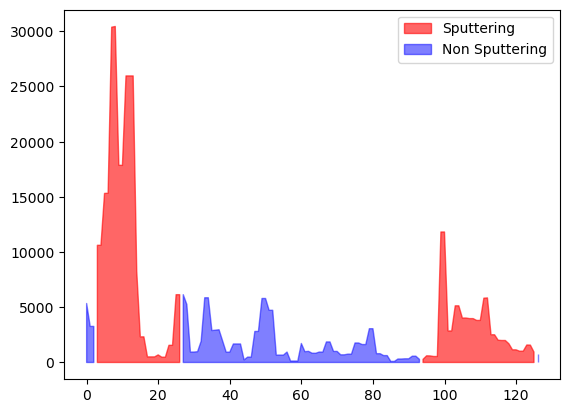

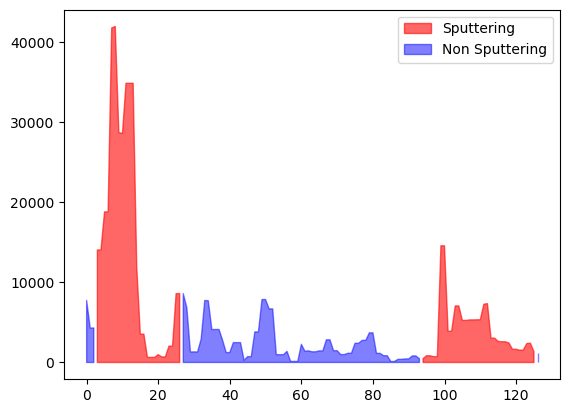

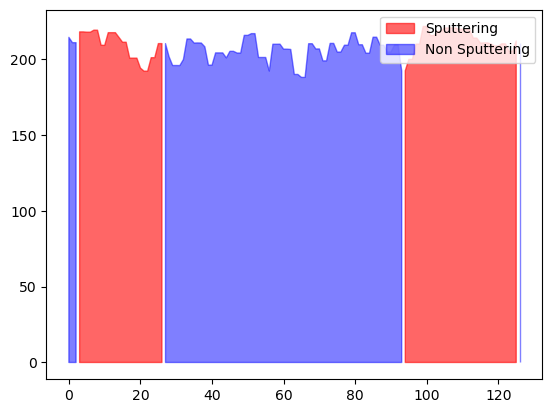

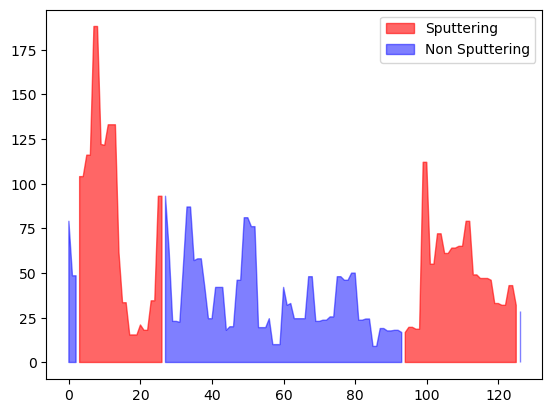

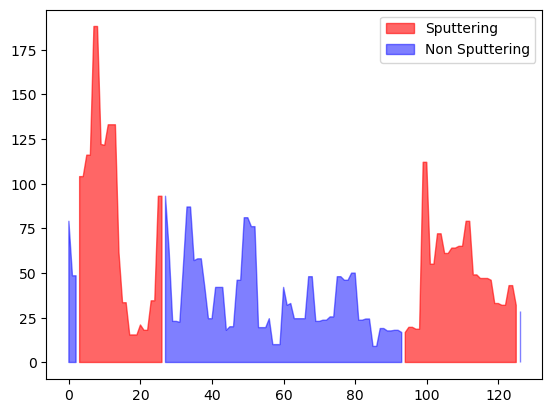

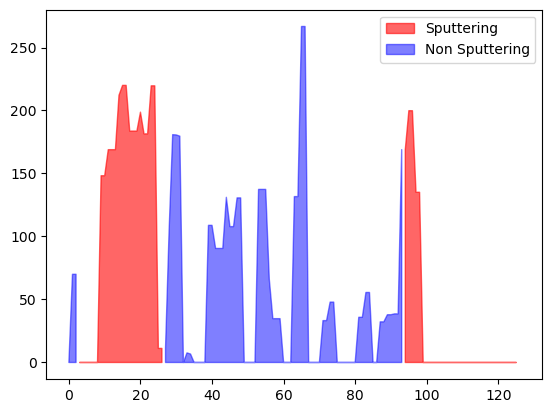

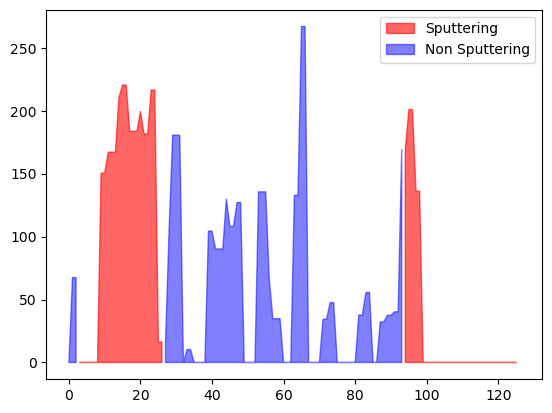

In [7]:
temp_df = df_lstm[(df_lstm['video'] == '2024-07-09_14_44_00_000') & (df_lstm['segment'] == 1)]
feature_cols = ['n_masks', 'avg_mask_area', 'avg_bbox_area',
       'avg_mask_strength', 'avg_bbox_width', 'avg_bbox_height',
       'mask_centroid_dist', 'bbox_centroid_dist']
temp_df.reset_index(inplace=True)
for feature in feature_cols:
    plt.figure()
    
#     plt.plot( temp_df[feature])
    # plt.plot(temp_df[temp_df['label_LSTM'] == 1]['n_masks'], marker='o', color='r')
#     max_val = 
    plt.fill_between(temp_df.index, temp_df[feature],  where = temp_df['label_LSTM']==1, color='red', alpha=0.6, label='Sputtering')
    plt.fill_between(temp_df.index, temp_df[feature],  where = temp_df['label_LSTM']==0, color='blue', alpha=0.5, label='Non Sputtering')
    plt.legend()
#     plt.title(feature)


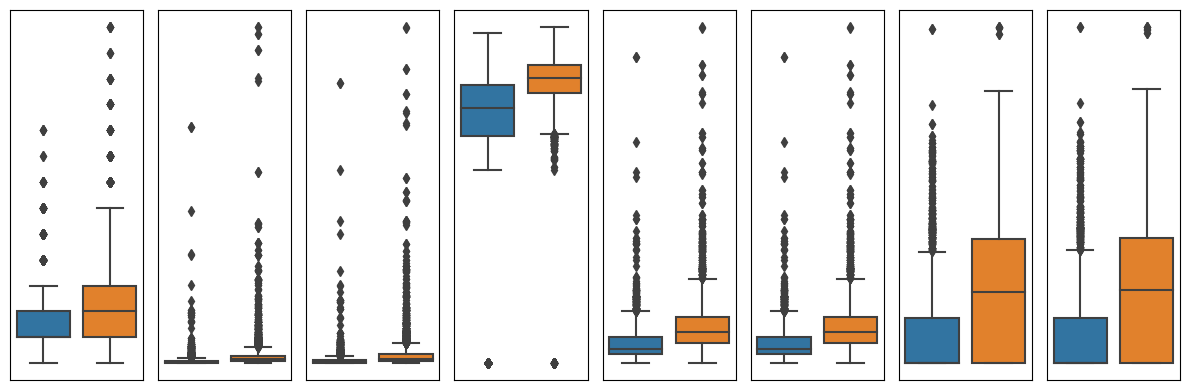

In [13]:
plt.figure(figsize=(12,4))
i = 1
for feature in feature_cols:

    plt.subplot(1,len(feature_cols),i)
    sns.boxplot(data=df_lstm, y=feature, x = 'label_LSTM')
    # plt.subplot(1,6,2)
    # sns.boxplot(data=df_lstm, y='avg_mask_area', x = 'label_LSTM')
    # plt.subplot(1,6,3)
    # sns.boxplot(data=df_lstm, y='mask_centroid_dist', x = 'label_LSTM')
    # plt.subplot(1,6,4)
    # sns.boxplot(data=df_lstm, y='avg_bbox_width', x = 'label_LSTM')
    # plt.subplot(1,6,5)
    # sns.boxplot(data=df_lstm, y='mask_centroid_dist', x = 'label_LSTM')
    # plt.subplot(1,6,6)
    # sns.boxplot(data=df_lstm, y='bbox_centroid_dist', x = 'label_LSTM')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])
    i += 1
plt.tight_layout()

In [16]:
corr = df_lstm[feature_cols].corr()
# sns.heatmap(df_lstm[feature_cols].corr(), annot=True)

In [18]:
corr.to_csv('test.csv')

In [19]:
corr_m = pd.read_csv('test.csv')

<Axes: ylabel='Unnamed: 0'>

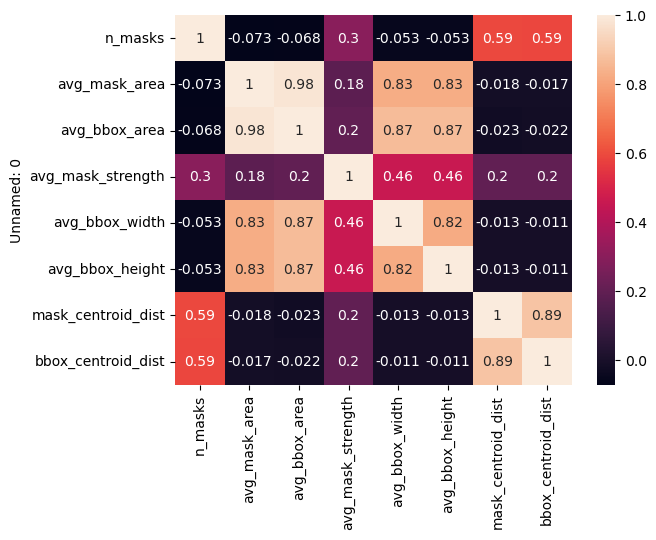

In [22]:
sns.heatmap(corr_m.set_index('Unnamed: 0'), annot=True)